<a href="https://colab.research.google.com/github/FabioMMaia/ANN_from_scratch/blob/main/T_7_Fabio_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Implementação da Classe RNA

In [ ]:
### RNA com alpha fixo ###

class RNA():

  def __init__(self,h=5, nepocasmax = 50000, early_stop=False):
    self.h = 5
    self.nepocasmax = nepocasmax
    self.alfa = 0.1
    self.early_stop=early_stop

  def fit(self, Xtr, Ytr, Xval, Yval):
    self.Xtr = Xtr.values
    self.Ytr = Ytr.values
    self.Xval = Xval.values
    self.Yval = Yval.values
    (self.Ntr,self.ne) = Xtr.shape
    (self.Nval,_ )=Xval.shape
    self.ns= Ytr.shape[1]
    self.Aot = None
    self.Bot = None

    # adciona o bias 
    self.Xtr = np.c_[ self.Xtr, np.ones(self.Ntr)]
    self.Xval = np.c_[ self.Xval, np.ones(self.Nval)]

    # Gerar as matrizes de pesos
    A= np.random.random((self.h,self.ne + 1))/2
    B= np.random.random((self.ns,self.h + 1))/2

    # calcula a saida
    Y= self.forward(self.Xtr,A,B,self.Ntr)
    
    # calcula erro
    erro_tr = Y - Ytr

    # Calcula do MSE
    EQM= (erro_tr**2).sum().sum()/self.Ntr

    # Calcular o gradiente
    (dJdA,dJdB)=self.calc_grad(self.Xtr,self.Ytr,A,B,self.Ntr);
    g=  np.concatenate([dJdA.flatten(), dJdB.flatten()])
    nep = 0
    vetErro_tr=[]
    vetErro_val=[]
    # vetErro.append(EQM)

    # faz o forward
    Yv=self.forward(self.Xval,A,B,self.Nval)
    erro_val= Yv-Yval
    EQM_val_ant= (erro_val**2).sum().sum()/self.Nval
    cont=0

    # condição de parada
    while np.linalg.norm(g)>1e-5 and nep<self.nepocasmax:
      nep=nep+1

      # gradiente descendente
      A = A - self.alfa*dJdA;
      B = B - self.alfa*dJdB;

      # backward
      (dJdA,dJdB)=self.calc_grad(self.Xtr,self.Ytr,A,B,self.Ntr)
      g=  np.concatenate([dJdA.flatten(), dJdB.flatten()])

      # Calcula erro de treino e validacao
      Y = self.forward(self.Xtr,A,B,self.Ntr)
      erro_tr= Y-Ytr
      EQM_tr= (erro_tr**2).sum().sum()/self.Ntr
      vetErro_tr.append(EQM_tr)
      Yv=self.forward(self.Xval,A,B,self.Nval)
      erro_val= Yv-Yval
      EQM_val= (erro_val**2).sum().sum()/self.Nval
      vetErro_val.append(EQM_val)

      if nep%1000==0:
        print('nep:', nep, 'EQM:', EQM, 'EQM_val:', EQM_val, 'norm:', np.linalg.norm(g))
      
      if EQM_val_ant>EQM_val:
        self.Aot = A
        self.Bot = B
        EQM_val_ant= EQM_val
        cont=0
      else:
        cont+=1
    
      if cont>100 and self.early_stop:
        break

    print('Convergência em {} epochs'.format(nep))
    self.iter_conv = nep
    self.vetErro_tr = vetErro_tr
    self.vetErro_val = vetErro_val
    return Y, Yv

  def forward(self, X, A, B, N):
    Zin = np.dot(X, A.T)
    Z=1./(1+np.exp(-Zin))
    Z= np.c_[ Z, np.ones(N)]
    Yin = np.dot(Z,B.T)
    Y= 1./(1+np.exp(-Yin))
    return Y

  def calc_grad(self,Xtr,Ytr,A,B,N):
    Zin = np.dot(Xtr,A.T)
    Z=1./(1+np.exp(-Zin))
    gl=(1-Z)*Z;
    Z= np.c_[ Z, np.ones(N)]
    Yin = np.dot(Z,B.T)
    Y= 1./(1+np.exp(-Yin))
    erro = Y-Ytr
    fl = (1-Y)*Y
    dJdB = 1/N*np.dot((erro*fl).T, Z)
    dJdZ = np.dot((erro*fl),B[:,:-1])
    dJdA = 1/N*np.dot((dJdZ*gl).T, Xtr)
    return (dJdA, dJdB)

In [ ]:
### RNA + bissecao ###

class RNA_Bissecao(RNA):

  def __init__(self,h=5, nepocasmax = 50000, early_stop=False, epsilon_bissec=1e-5, itmax_bissec=50):
    super().__init__(h,nepocasmax, early_stop)
    self.epsilon_bissec=epsilon_bissec
    self.itmax_bissec = itmax_bissec

  def fit(self, Xtr, Ytr, Xval, Yval):
    self.Xtr = Xtr.values
    self.Ytr = Ytr.values
    self.Xval = Xval.values
    self.Yval = Yval.values
    (self.Ntr,self.ne) = Xtr.shape
    (self.Nval,_ )=Xval.shape
    self.ns= Ytr.shape[1]
    self.Aot = None
    self.Bot = None

    # adciona o bias 
    self.Xtr = np.c_[ self.Xtr, np.ones(self.Ntr)]
    self.Xval = np.c_[ self.Xval, np.ones(self.Nval)]

    # Gerar as matrizes de pesos
    A= np.random.random((self.h,self.ne + 1))/2
    B= np.random.random((self.ns,self.h + 1))/2

    # calcula a saida
    Y= self.forward(self.Xtr,A,B,self.Ntr)
    
    # calcula erro
    erro_tr = Y - Ytr

    # Calcula do MSE
    EQM= (erro_tr**2).sum().sum()/self.Ntr

    # Calcular o gradiente
    (dJdA,dJdB)=self.calc_grad(self.Xtr,self.Ytr,A,B,self.Ntr);
    g=  np.concatenate([dJdA.flatten(), dJdB.flatten()])
    nep = 0
    vetErro_tr=[]
    vetErro_val=[]
    # vetErro_tr.append(EQM)

    # faz o forward
    Yv=self.forward(self.Xval,A,B,self.Nval)
    erro_val= Yv-Yval
    EQM_val_ant= (erro_val**2).sum().sum()/self.Nval
    cont=0

    # condição de parada
    while np.linalg.norm(g)>1e-4 and nep<self.nepocasmax:
      nep=nep+1

      # gradiente descendente
      alfa = self.calculate_alfa(dJdA,dJdB,A,B)
      A = A - alfa*dJdA;
      B = B - alfa*dJdB;

      # backward
      (dJdA,dJdB)=self.calc_grad(self.Xtr,self.Ytr,A,B,self.Ntr)
      g=  np.concatenate([dJdA.flatten(), dJdB.flatten()])

      # Calcula erro de treino e validacao
      Y = self.forward(self.Xtr,A,B,self.Ntr)
      erro_tr= Y-Ytr
      EQM= (erro_tr**2).sum().sum()/self.Ntr
      vetErro_tr.append(EQM)
      Yv=self.forward(self.Xval,A,B,self.Nval)
      erro_val= Yv-Yval
      EQM_val= (erro_val**2).sum().sum()/self.Nval
      vetErro_val.append(EQM_val)

      if nep%1000==0:
        print('nep:', nep, 'EQM:', EQM, 'EQM_val:', EQM_val, 'norm:', np.linalg.norm(g), 'alfa:', alfa)
      
      if EQM_val_ant>EQM_val:
        self.Aot = A
        self.Bot = B
        EQM_val_ant= EQM_val
        cont=0
      else:
        cont+=1
    
      if cont>100 and self.early_stop:
        break

    # print('Convergência em {} epochs'.format(nep))
    self.iter_conv = nep
    self.vetErro_tr = vetErro_tr
    self.vetErro_val = vetErro_val

    return Y, Yv

  def calculate_alfa(self, dJdA,dJdB,A,B):
    
    dv = np.concatenate([-dJdA.flatten() ,-dJdB.flatten()])
    alfa_u = np.random.random()
    An = A - alfa_u*dJdA
    Bn = B - alfa_u*dJdB

    (dJdAn,dJdBn)=self.calc_grad(self.Xtr,self.Ytr,An,Bn,self.Ntr)
    g = np.concatenate([dJdAn.flatten() , dJdBn.flatten()])
    hl = np.dot(g.T, dv)

    alfa_l=0
    while hl<0:
      alfa_l = alfa_u
      alfa_u = alfa_u*2
      An = A - alfa_u*dJdA
      Bn = B - alfa_u*dJdB
      (dJdAn,dJdBn)=self.calc_grad(self.Xtr,self.Ytr,An,Bn,self.Ntr)
      g = np.concatenate([dJdAn.flatten() , dJdBn.flatten()])
      hl = np.dot(g.T, dv)

    kmax = np.ceil(np.log2((alfa_u-alfa_l)/self.epsilon_bissec))
    it=0

    while it<kmax and it<self.itmax_bissec and abs(hl)>self.epsilon_bissec:
      # print('kmax:', kmax, 'it:',it, 'alfa_m:',  (alfa_l + alfa_u)/2, 'hl:', hl)
      it+=1
      alfa_m = (alfa_l + alfa_u)/2
      An = A - alfa_u*dJdA
      Bn = B - alfa_u*dJdB
      (dJdAn,dJdBn)=self.calc_grad(self.Xtr,self.Ytr,An,Bn,self.Ntr)
      g = np.concatenate([dJdAn.flatten() , dJdBn.flatten()])
      hl = np.dot(g.T, dv)

      if abs(hl)<1e-3:
        break
      elif hl>0:
        alfa_u = alfa_m
      elif hl <0:
        alfa_l = alfa_m
    

    alfa_m = (alfa_l + alfa_u)/2

    return alfa_m

# Testando no datset Breast Cancer

In [ ]:
def PipeLine_Model(model, X, y, perc_train):

  m = X.shape[0]
  X = (X - X.min())/(X.max() - X.min())

  Xtr = X.iloc[:round(m*.8),:]
  Xval = X.iloc[round(m*.8):,:]

  Ytr = y.iloc[:round(m*.8),:]
  Yval = y.iloc[round(m*.8):,:]

  Ypred_train,Ypred_val =  model.fit(Xtr, Ytr, Xval, Yval)

  print('Acuracia no treino:', ((Ypred_train>0.5).astype(float)==Ytr.values).mean())
  print('Acuracia na validação:', ((Ypred_val>0.5).astype(float)==Yval.values).mean())

  plt.figure(figsize=(8, 6), dpi=80)
  plt.plot(model.vetErro_tr, alpha=.75);
  plt.plot(model.vetErro_val, alpha=.75);
  plt.xlabel('iteracao');
  plt.ylabel('erro');
  plt.legend()
  plt.show()

  return model

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns= cancer.feature_names)
y = pd.DataFrame(cancer.target, columns= ['target'])

In [ ]:
# RNA com alpha fixo 
rna = RNA(h=3)
PipeLine_Model(rna, X, y, 0.8);

Acuracia no treino: 0.9956043956043956
Acuracia na validação: 0.9649122807017544


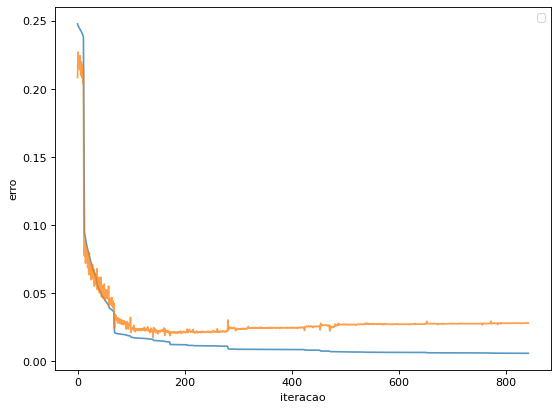

In [ ]:
# RNA + bissecao
rna_b = RNA_Bissecao(h=3)
PipeLine_Model(rna_b, X, y, 0.8);

# PipeLine de Teste

In [ ]:
class PipeLine():
  
  def __init__(self,model, X, y, h_values=[5], hold_out_perc=0.8, rounds=2, n_folds=5, seed=10):
    self.model = model
    self.h_values= h_values
    self.hold_out_perc = hold_out_perc
    self.rounds = rounds
    self.X=X
    self.y=y
    self.m = X.shape[0]
    self.n_folds = n_folds 
    self.seed=seed
    np.random.seed(seed)

  def hold_out_n_round(self):

    self.accuracies_df = pd.DataFrame()
    final_results = {}

    for round in range(0,self.rounds):
      print('round:',round)
      perm = np.random.permutation(self.X.index)
      X_shuffle= X.reindex(perm).copy()
      y_shuffle= y.reindex(perm).copy()

      XTR = X_shuffle.iloc[:int(self.m*self.hold_out_perc),:]
      XTST = X_shuffle.iloc[int(self.m*self.hold_out_perc):,:]

      YTR = y_shuffle.iloc[:int(self.m*self.hold_out_perc),:]
      YTST = y_shuffle.iloc[int(self.m*self.hold_out_perc):,:]

      # constroi matriz dos melhores parametros por cv e seleciona melhor parametro
      accuracies_round = self.cross_validation(XTR, YTR)
      accuracies_round_df = pd.DataFrame(accuracies_round).reset_index()
      accuracies_round_df['h'] = accuracies_round_df['index'].apply(lambda x:x.split('_')[0])
      accuracies_round_df['round'] = round
      self.accuracies_df = self.accuracies_df.append(accuracies_round_df)
      best_h = accuracies_round_df.groupby('h').mean().sort_values(by='val',ascending=False).index[0]

      # Normaliza
      XTR_norm = (XTR - XTR.mean())/ XTR.std()
      XTST_norm = (XTST - XTR.mean())/ XTR.std()

      # Aplica o melhor parâmetro
      self.model.h = int(best_h)
      YPRED_TR,YPRED_TST =  self.model.fit(XTR_norm, YTR, XTST_norm, YTST)

      acc_TR = ((YPRED_TR>0.5).astype(float)==YTR.values).mean()
      acc_TST = ((YPRED_TST>0.5).astype(float)==YTST.values).mean()

      final_results[str(round)] = (best_h, acc_TR,acc_TST)

    return final_results

  def return_indexes_kfold(self, Xcv):
    m_cv = Xcv.shape[0]

    edges = np.arange(0,1+1/self.n_folds,1/self.n_folds)
    edges = [int(m_cv*edge) for edge in edges]

    indexes = {}

    for n in range(len(edges)-1):

      left = edges[n]
      if n== len(edges)-1:
        right= m_cv - 1
      else:
        right = edges[n+1]

      indexes[n] = np.arange(left, right, 1)

    return indexes


  def cross_validation(self, Xcv, ycv, norm=True):

    all_ids = np.arange(0, Xcv.shape[0], 1)
    indexes_kfold = self.return_indexes_kfold(Xcv)
    acc_tr_m = {}
    acc_val_m = {}

    for h in self.h_values:
      self.model.h = h

      fig, ax = plt.subplots(1,5, figsize=(22, 6))
        
      print('Usando {} neuronios'.format(h))
    
      for chunk_id in indexes_kfold.keys():
        
        val_id = list(indexes_kfold[chunk_id])
        train_id = list(set(all_ids) - set(val_id))
        # print('validation chunk:{} - m_val = {}  m_train= {}'.format(chunk_id, len(val_id), len(train_id)))

        Xtr = Xcv.copy().iloc[train_id]
        Ytr = ycv.copy().iloc[train_id]

        Xval = Xcv.copy().iloc[val_id]
        Yval = ycv.copy().iloc[val_id]

        if norm:
          Xtr_norm = (Xtr - Xtr.mean())/ Xtr.std()
          Xval_norm = (Xval - Xtr.mean())/ Xtr.std()

        Ypred_train,Ypred_val =  self.model.fit(Xtr_norm, Ytr, Xval_norm, Yval)

        acc_train, acc_val = self.calculate_accuracy(Ytr,Ypred_train,Yval,Ypred_val)

        acc_tr_m[str(h)+'_'+str(chunk_id)] = acc_train
        acc_val_m[str(h)+'_'+str(chunk_id)] = acc_val
      

        # plt.figure(figsize=(4, 3), dpi=80);
        ax[chunk_id].plot(self.model.vetErro_tr, alpha=.75, label='erro_tr');
        ax[chunk_id].plot(self.model.vetErro_val, alpha=.75, label='erro_val');
        ax[chunk_id].set_xlabel('iteracao');
        ax[chunk_id].set_ylabel('erro');
        ax[chunk_id].set_title('it:{} n_iter:{} acc: tr:{:.2f} val:{:.2f}'.format(chunk_id,self.model.iter_conv, acc_train, acc_val))
        
      plt.legend();
      plt.tight_layout();
      plt.show();
      accuracies ={}
      accuracies['train'] = acc_tr_m
      accuracies['val'] = acc_val_m
    return accuracies

  def calculate_accuracy(self, y_train, y_train_hat, y_val, y_val_hat, threshold=.5):
    acc_train = ((y_train_hat>threshold).astype(float)==y_train.values).mean()
    acc_val = ((y_val_hat>threshold).astype(float)==y_val.values).mean()
    return (acc_train, acc_val )

round: 0
Usando 3 neuronios


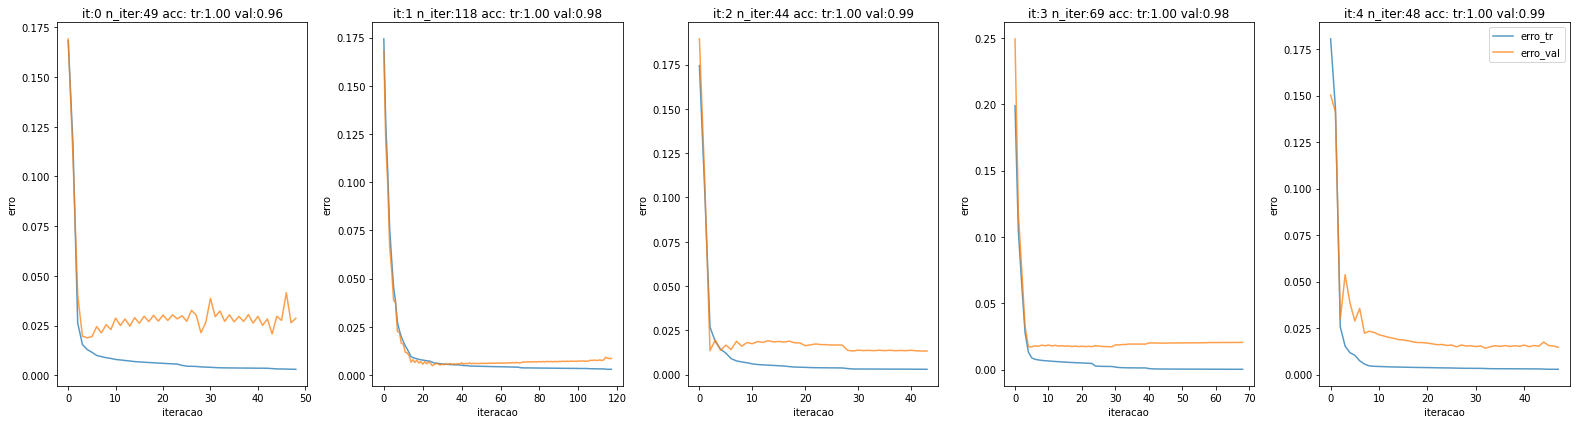

Usando 5 neuronios


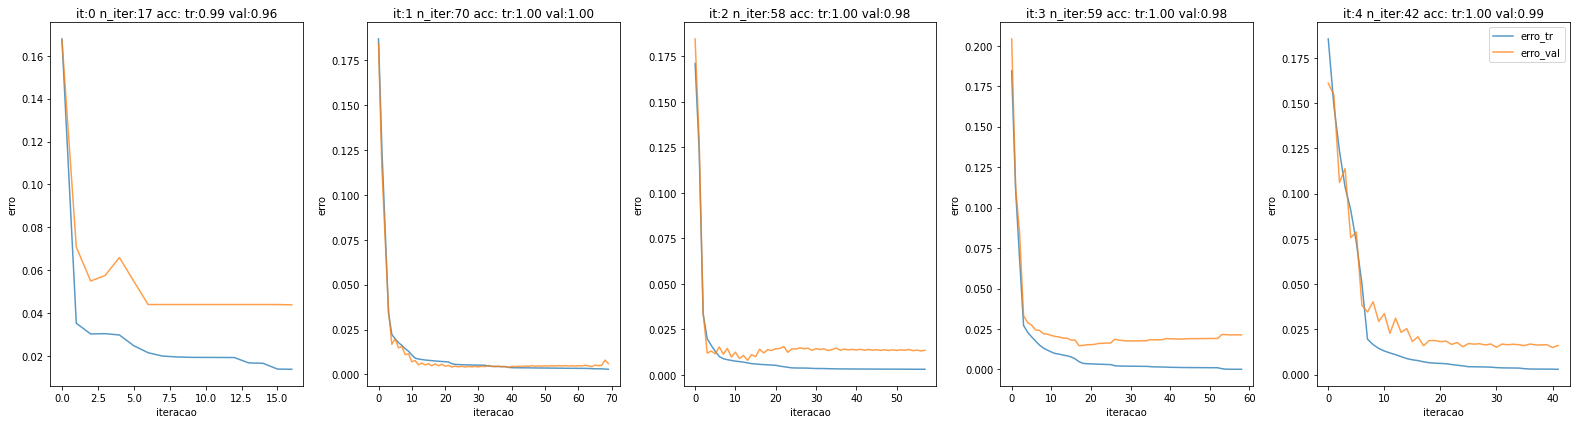

Usando 10 neuronios


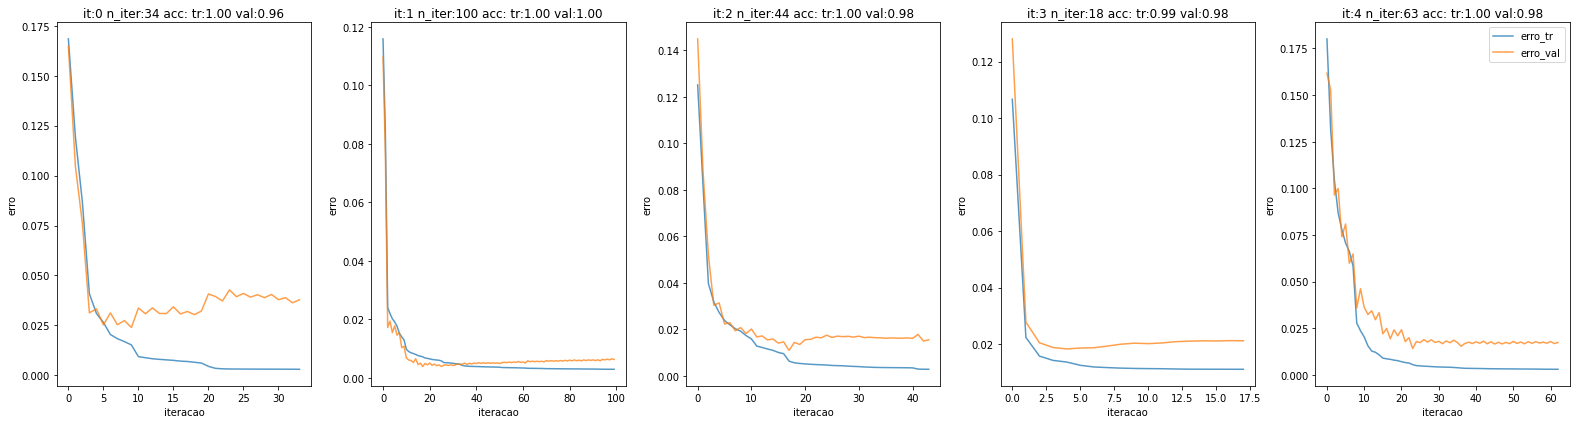

round: 1
Usando 3 neuronios


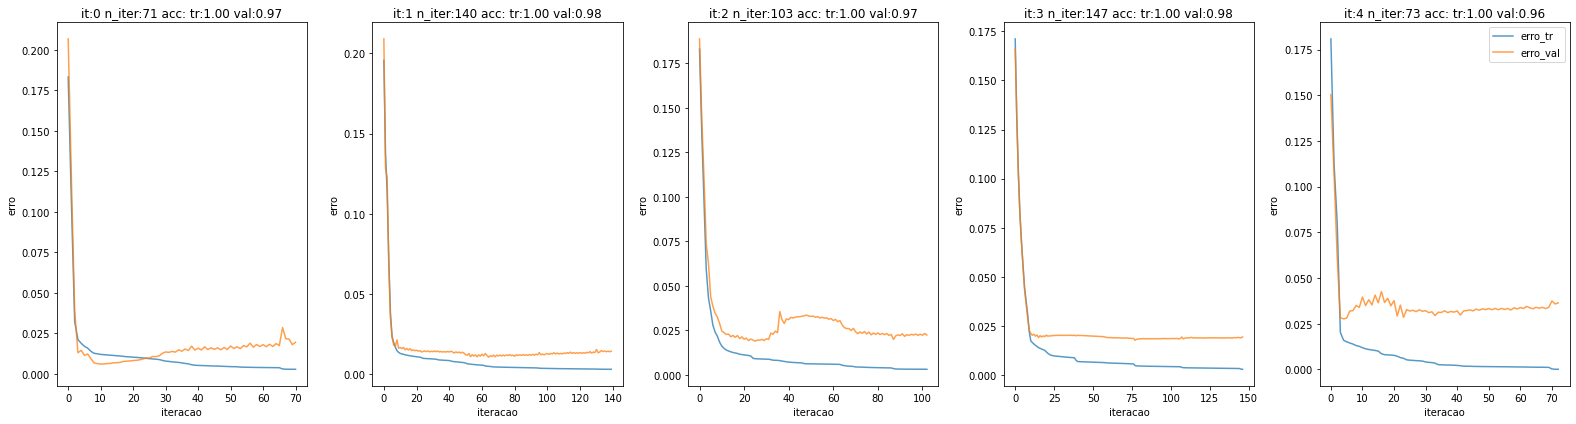

Usando 5 neuronios


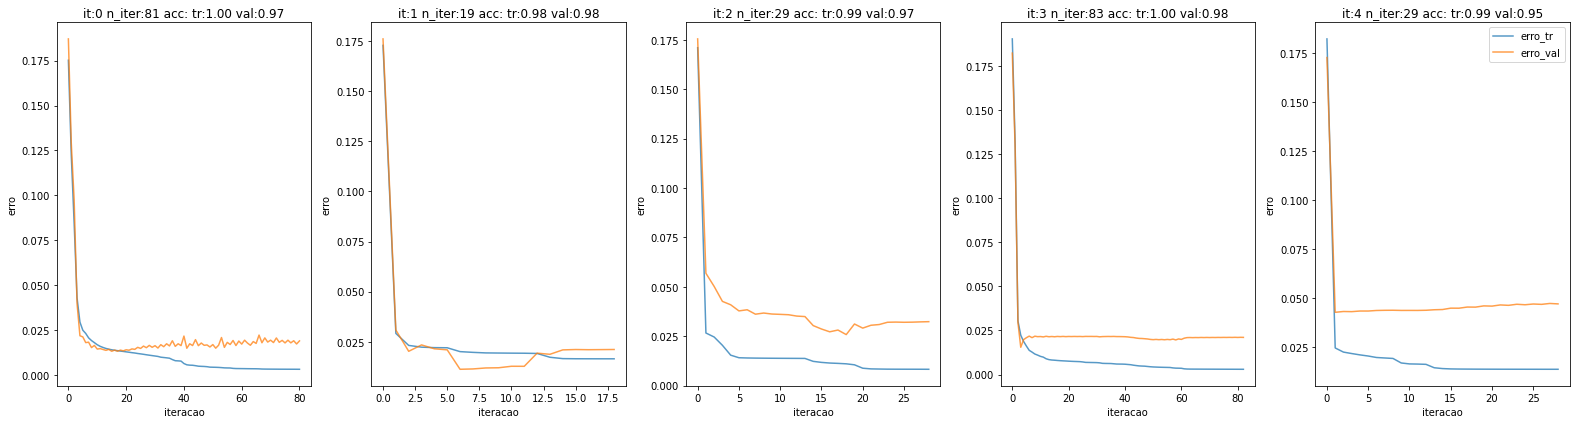

Usando 10 neuronios


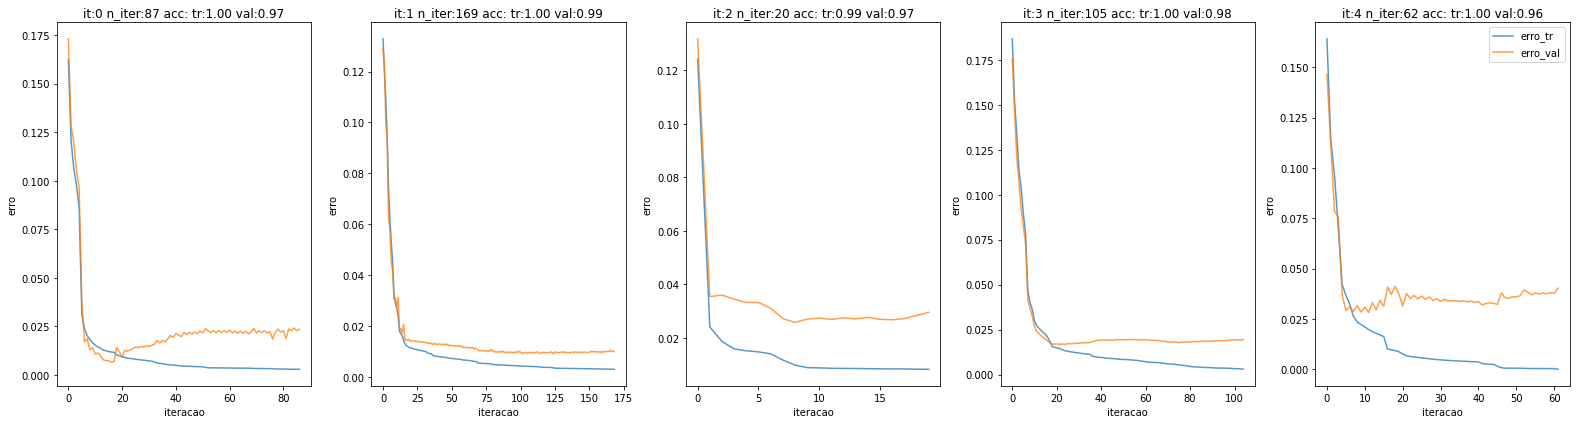

round: 2
Usando 3 neuronios


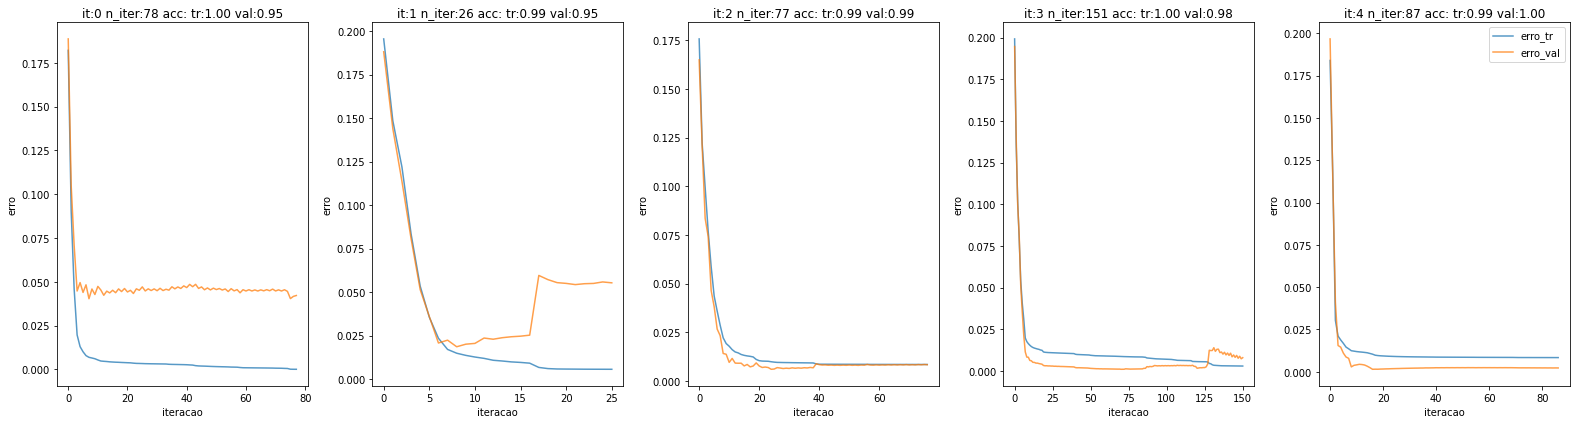

Usando 5 neuronios


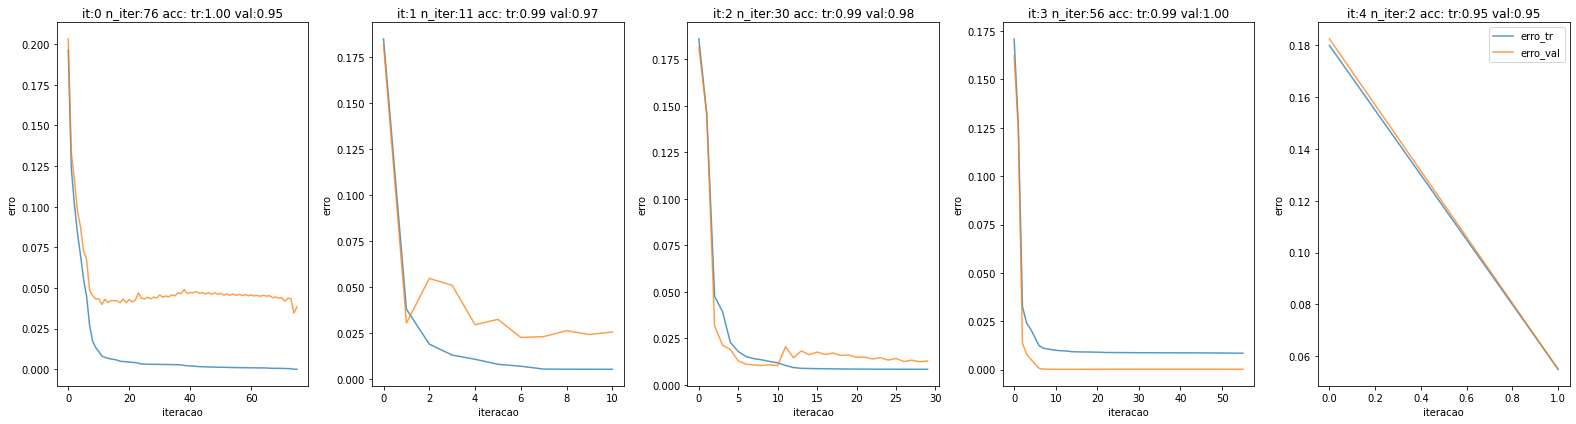

Usando 10 neuronios


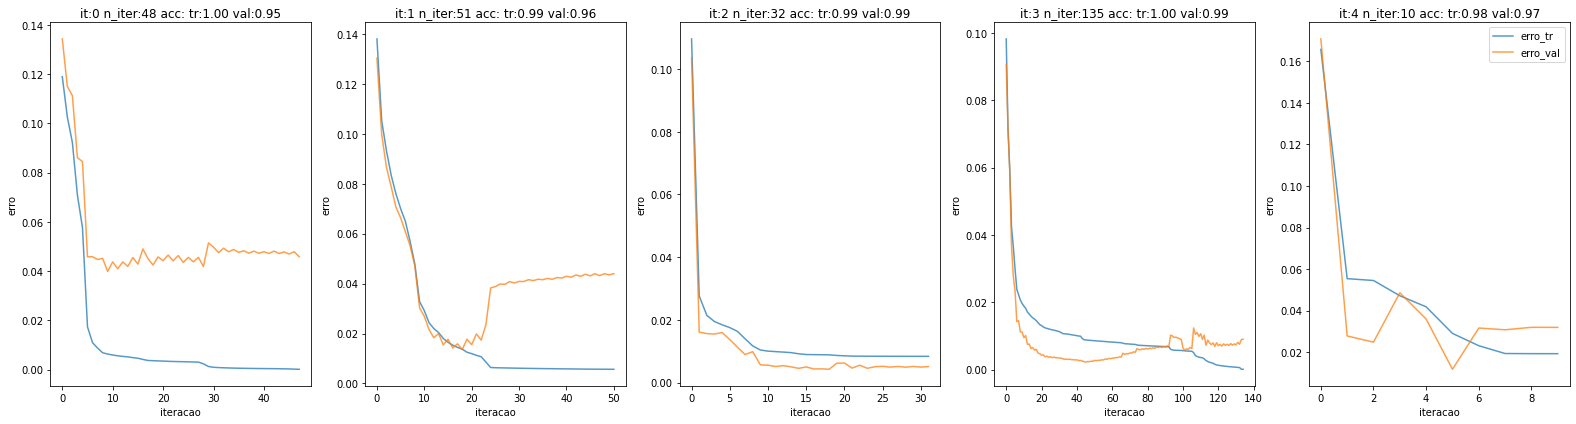

round: 3
Usando 3 neuronios


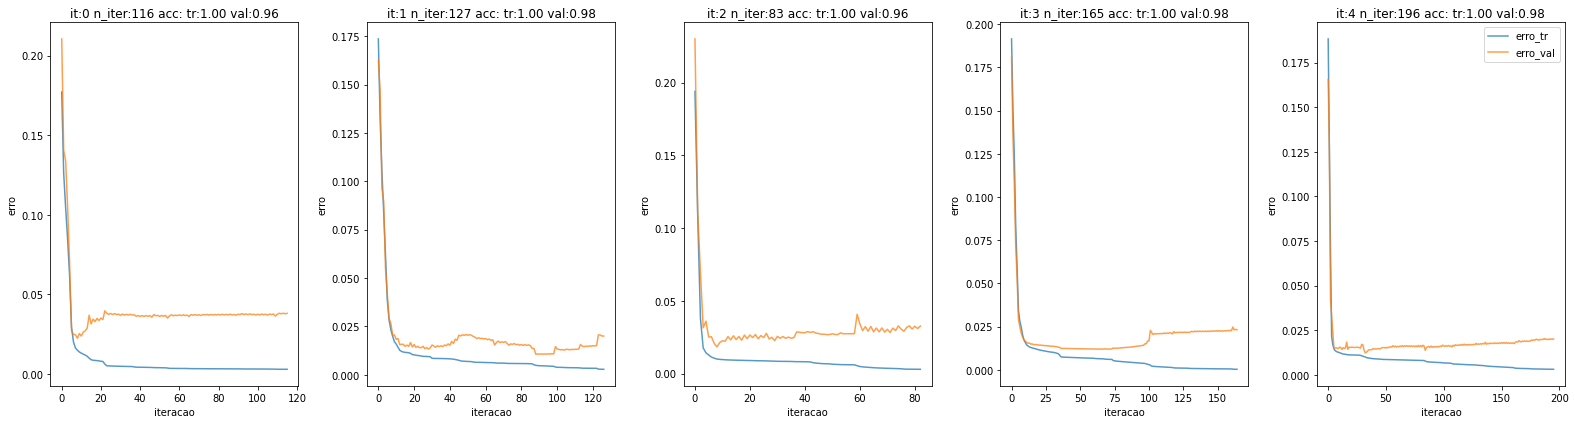

Usando 5 neuronios


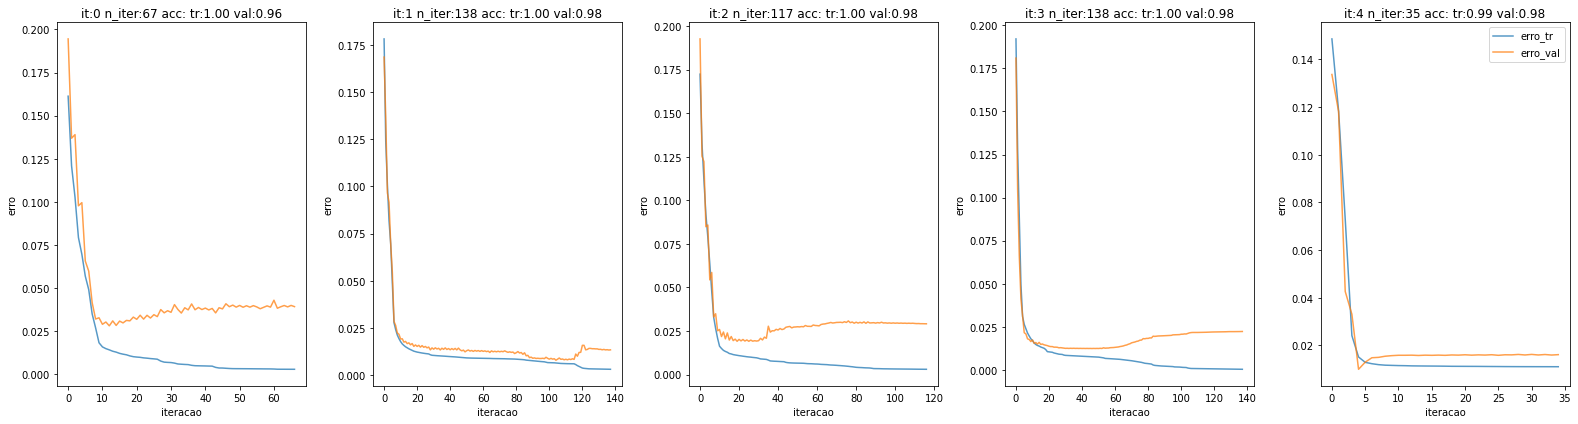

Usando 10 neuronios


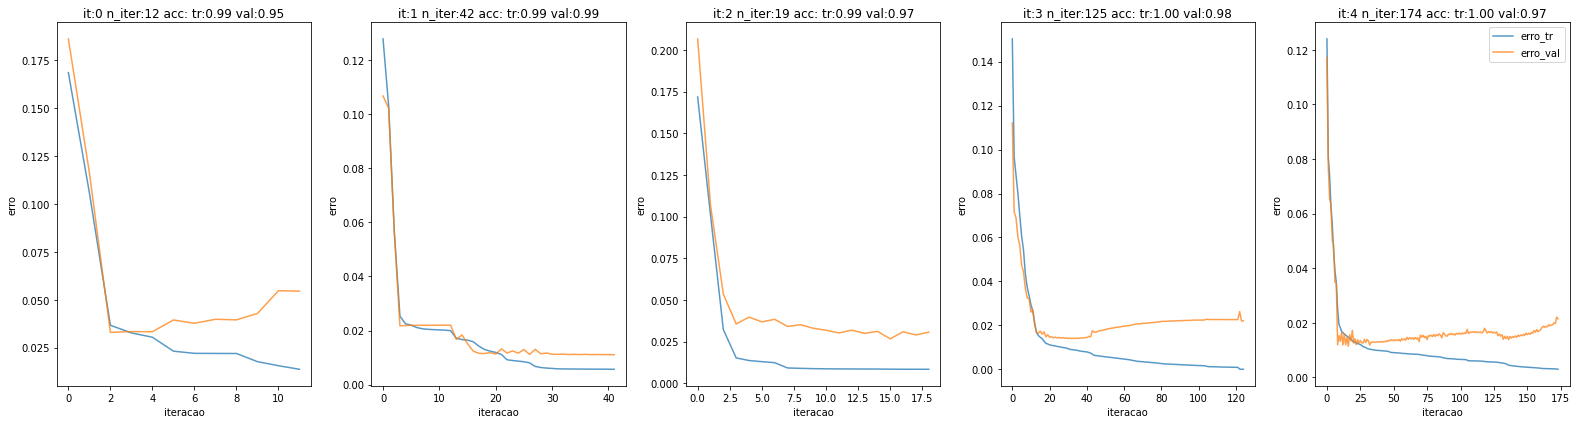

round: 4
Usando 3 neuronios


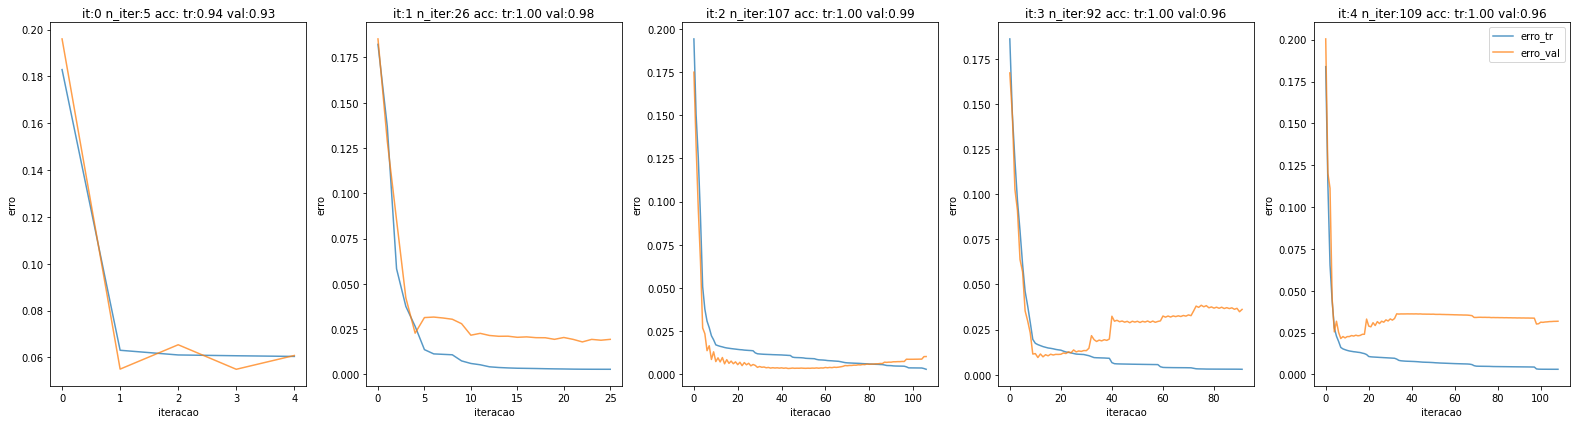

Usando 5 neuronios


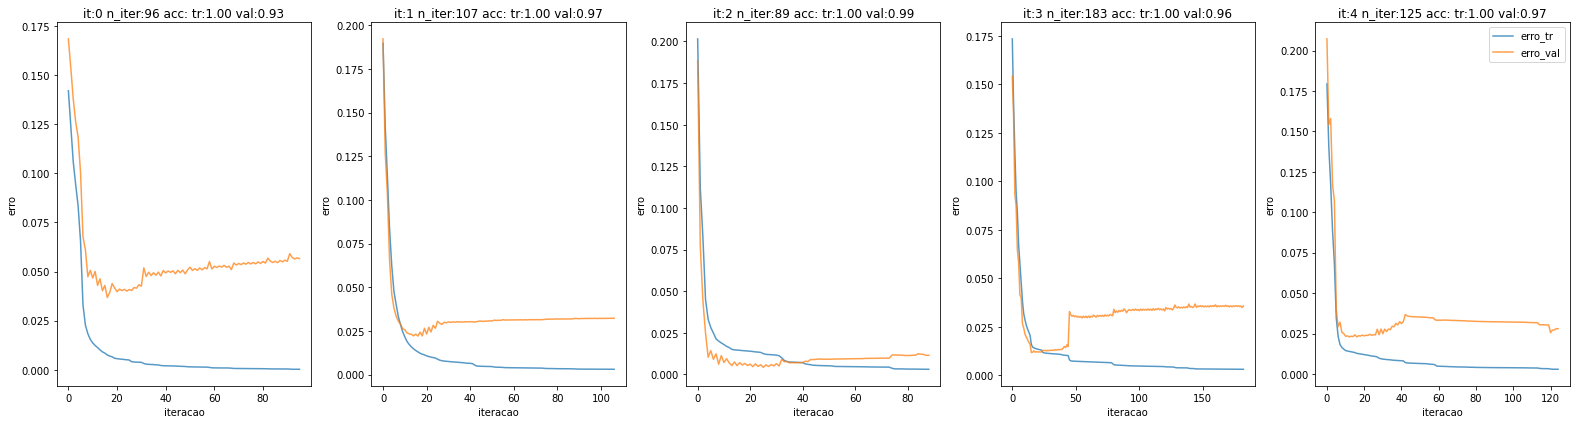

Usando 10 neuronios


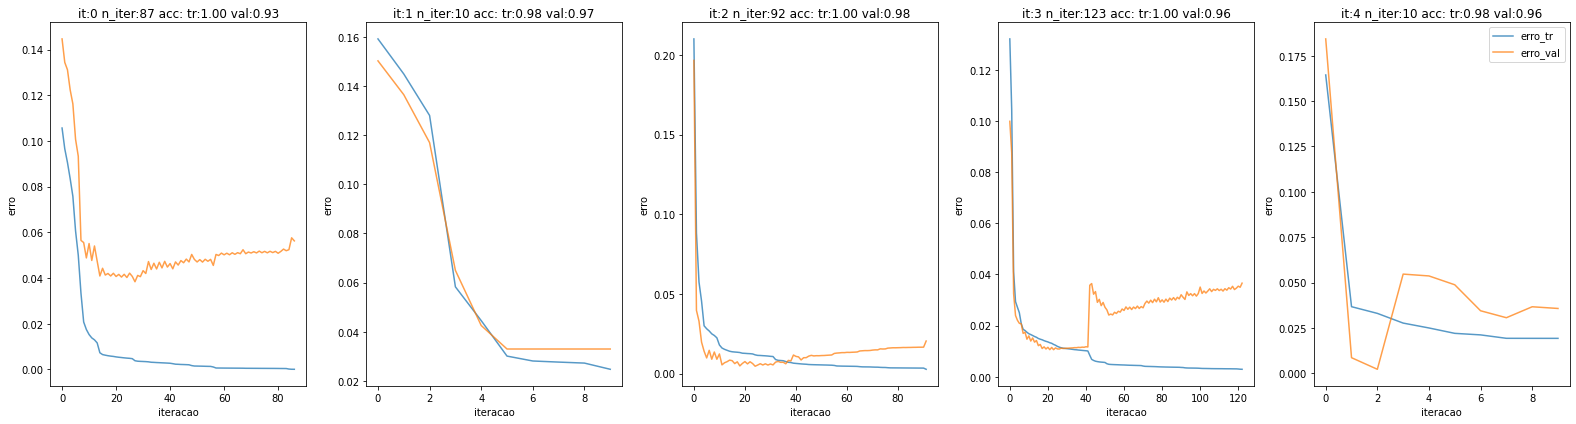

{'0': ('5', 0.9978021978021978, 0.9649122807017544),
 '1': ('10', 0.9868131868131869, 0.9736842105263158),
 '2': ('3', 0.9956043956043956, 0.9736842105263158),
 '3': ('5', 0.9846153846153847, 0.9649122807017544),
 '4': ('3', 0.9978021978021978, 0.9736842105263158)}

In [ ]:
rna_b = RNA_Bissecao()
h_values = [3,5,10]
pipe = PipeLine(rna_b, X, y, h_values,rounds=5)
pipe.hold_out_n_round()

# Testando com Dataset - ECF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset= pd.read_csv('/content/drive/MyDrive/SIN5016 - Dataset/SUBJECT_concatenado.csv')

In [ ]:
dataset = dataset.drop(columns = 'Unnamed: 0')

In [ ]:
print('Dimensoes do dataset:', dataset.shape)
print('Após transpor 512 linhas:', dataset.shape[0]/512)

Dimensoes do dataset: (1096192, 33)
Após transpor 512 linhas: 2141.0


In [ ]:
assert (dataset['32'].groupby(dataset.index // 512).mean()%1==0).all()

In [ ]:
X_all = pd.DataFrame()

for n in range(int(dataset.shape[0]/512)):
  X_row = pd.DataFrame(dataset.iloc[512*n:512*(n+1),:32].values.reshape(1,-1))
  X_all=X_all.append(X_row, ignore_index=True)

In [ ]:
y_all = dataset['32'].groupby(dataset.index // 512).mean().astype(int).to_frame()

In [ ]:
assert X_all.shape[0]== int(dataset.shape[0]/512)

In [ ]:
assert X_all.shape[0]==y_all.shape[0]

In [ ]:
def test_pipeline_rna_b(X, y, h_rna = 30 , pca_n = 5):
  np.random.seed(10)
  perm = np.random.permutation(X_all.index)
  X= X.copy().reindex(perm)
  y = y.copy().reindex(perm)
  m= X.shape[0]

  Xtr = X.iloc[:round(m*.8),:]
  Xval = X.iloc[round(m*.8):,:]

  Ytr = y.iloc[:round(m*.8),:]
  Yval = y.iloc[round(m*.8):,:]

  Xtr_norm = (Xtr - Xtr.mean())/ Xtr.std()
  Xval_norm = (Xval - Xtr.mean())/ Xtr.std()

  pca = PCA(n_components=pca_n)
  pca.fit(Xtr_norm)

  Xtr_pca = pd.DataFrame(pca.transform(Xtr_norm))
  Xval_pca = pd.DataFrame(pca.transform(Xval_norm))

  Xtr_pca_norm = (Xtr_pca - Xtr_pca.mean())/ Xtr_pca.std()
  Xval_pca_norm = (Xval_pca - Xtr_pca.mean())/ Xtr_pca.std()

  Ytr_bool = pd.get_dummies(Ytr['32'].astype(str))
  Yval_bool = pd.get_dummies(Yval['32'].astype(str))

  rna = RNA_Bissecao(h=h_rna)
  Ypred_train,Ypred_val =  rna.fit(Xtr_pca_norm, Ytr_bool, Xval_pca_norm, Yval_bool)

  print('Acuracia no treino:', (pd.DataFrame(Ypred_train, columns = Ytr_bool.columns).idxmax(axis=1).reset_index(drop=True) ==Ytr_bool.idxmax(axis=1).reset_index(drop=True)).mean())
  print('Acuracia na validação:', (pd.DataFrame(Ypred_val, columns = Ytr_bool.columns).idxmax(axis=1).reset_index(drop=True) == Yval_bool.idxmax(axis=1).reset_index(drop=True)).mean())

  plt.figure(figsize=(8, 6), dpi=80)
  plt.plot(rna.vetErro_tr, alpha=.75, label='train');
  plt.plot(rna.vetErro_val, alpha=.75, label='val');
  plt.xlabel('iteracao');
  plt.ylabel('erro');
  plt.legend();

h:5 n_components:5
nep: 1000 EQM: 0.6259381106046024 EQM_val: 0.6594433009442747 norm: 0.0012129506855307981 alfa: 47.490760581981796
nep: 2000 EQM: 0.6200533433964921 EQM_val: 0.652526764467145 norm: 0.00021064719301642116 alfa: 2.0661120363844807
nep: 3000 EQM: 0.6156185852155104 EQM_val: 0.647215547870898 norm: 0.00043974529519488255 alfa: 3.621267972567477
nep: 4000 EQM: 0.6066248637178414 EQM_val: 0.6359532533915563 norm: 0.0005120924229800342 alfa: 1.8903086265375266
nep: 5000 EQM: 0.5954594411228279 EQM_val: 0.6317220100398123 norm: 0.0033875887013936545 alfa: 67.05198770917956
Acuracia no treino: 0.46293053123175715
Acuracia na validação: 0.4158878504672897
h:5 n_components:10
nep: 1000 EQM: 0.4921726651035038 EQM_val: 0.5524533188185304 norm: 0.00015820550275295168 alfa: 8.818949443554843
Acuracia no treino: 0.660245183887916
Acuracia na validação: 0.5537383177570093
h:5 n_components:15
nep: 1000 EQM: 0.4609338598056095 EQM_val: 0.5149240214533464 norm: 0.00019352335503152975 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.2763704030599545 EQM_val: 0.4677424840444563 norm: 0.0004069099850874321 alfa: 7.3801353621953965
Acuracia no treino: 0.848219497956801
Acuracia na validação: 0.7172897196261683
h:20 n_components:60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.1730360012152248 EQM_val: 0.46407200142493527 norm: 0.0005867344315325722 alfa: 18.832516103758092
nep: 2000 EQM: 0.1644610516933874 EQM_val: 0.48512938995647864 norm: 0.00018634070223790927 alfa: 4.550659831356431
Acuracia no treino: 0.9019264448336253
Acuracia na validação: 0.7289719626168224
h:20 n_components:90


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.11118198673160486 EQM_val: 0.632521146019349 norm: 0.0005789842218244635 alfa: 11.440412532638032
nep: 2000 EQM: 0.0976089237360291 EQM_val: 0.6888882682989879 norm: 0.00024977631491125934 alfa: 8.340387817301945
Acuracia no treino: 0.9363689433741973
Acuracia na validação: 0.6214953271028038
h:25 n_components:5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.6259381106046024 EQM_val: 0.6594433009442747 norm: 0.0012129506855307981 alfa: 47.490760581981796
nep: 2000 EQM: 0.6200533433964921 EQM_val: 0.652526764467145 norm: 0.00021064719301642116 alfa: 2.0661120363844807
nep: 3000 EQM: 0.6156185852155104 EQM_val: 0.647215547870898 norm: 0.00043974529519488255 alfa: 3.621267972567477
nep: 4000 EQM: 0.6066248637178414 EQM_val: 0.6359532533915563 norm: 0.0005120924229800342 alfa: 1.8903086265375266
nep: 5000 EQM: 0.5954594411228279 EQM_val: 0.6317220100398123 norm: 0.0033875887013936545 alfa: 67.05198770917956
Acuracia no treino: 0.46293053123175715
Acuracia na validação: 0.4158878504672897
h:25 n_components:10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.4921726651035038 EQM_val: 0.5524533188185304 norm: 0.00015820550275295168 alfa: 8.818949443554843
Acuracia no treino: 0.660245183887916
Acuracia na validação: 0.5537383177570093
h:25 n_components:15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.4609338598056095 EQM_val: 0.5149240214533464 norm: 0.00019352335503152975 alfa: 9.431540384945182
Acuracia no treino: 0.6503210741389376
Acuracia na validação: 0.5981308411214953
h:25 n_components:30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.2763704030599545 EQM_val: 0.4677424840444563 norm: 0.0004069099850874321 alfa: 7.3801353621953965
Acuracia no treino: 0.848219497956801
Acuracia na validação: 0.7172897196261683
h:25 n_components:60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.1730360012152248 EQM_val: 0.46407200142493527 norm: 0.0005867344315325722 alfa: 18.832516103758092
nep: 2000 EQM: 0.1644610516933874 EQM_val: 0.48512938995647864 norm: 0.00018634070223790927 alfa: 4.550659831356431
Acuracia no treino: 0.9019264448336253
Acuracia na validação: 0.7289719626168224
h:25 n_components:90


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.11118198673160486 EQM_val: 0.632521146019349 norm: 0.0005789842218244635 alfa: 11.440412532638032
nep: 2000 EQM: 0.0976089237360291 EQM_val: 0.6888882682989879 norm: 0.00024977631491125934 alfa: 8.340387817301945
Acuracia no treino: 0.9363689433741973
Acuracia na validação: 0.6214953271028038
h:50 n_components:5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.6259381106046024 EQM_val: 0.6594433009442747 norm: 0.0012129506855307981 alfa: 47.490760581981796
nep: 2000 EQM: 0.6200533433964921 EQM_val: 0.652526764467145 norm: 0.00021064719301642116 alfa: 2.0661120363844807
nep: 3000 EQM: 0.6156185852155104 EQM_val: 0.647215547870898 norm: 0.00043974529519488255 alfa: 3.621267972567477
nep: 4000 EQM: 0.6066248637178414 EQM_val: 0.6359532533915563 norm: 0.0005120924229800342 alfa: 1.8903086265375266
nep: 5000 EQM: 0.5954594411228279 EQM_val: 0.6317220100398123 norm: 0.0033875887013936545 alfa: 67.05198770917956
Acuracia no treino: 0.46293053123175715
Acuracia na validação: 0.4158878504672897
h:50 n_components:10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.4921726651035038 EQM_val: 0.5524533188185304 norm: 0.00015820550275295168 alfa: 8.818949443554843
Acuracia no treino: 0.660245183887916
Acuracia na validação: 0.5537383177570093
h:50 n_components:15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.4609338598056095 EQM_val: 0.5149240214533464 norm: 0.00019352335503152975 alfa: 9.431540384945182
Acuracia no treino: 0.6503210741389376
Acuracia na validação: 0.5981308411214953
h:50 n_components:30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.2763704030599545 EQM_val: 0.4677424840444563 norm: 0.0004069099850874321 alfa: 7.3801353621953965
Acuracia no treino: 0.848219497956801
Acuracia na validação: 0.7172897196261683
h:50 n_components:60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.1730360012152248 EQM_val: 0.46407200142493527 norm: 0.0005867344315325722 alfa: 18.832516103758092
nep: 2000 EQM: 0.1644610516933874 EQM_val: 0.48512938995647864 norm: 0.00018634070223790927 alfa: 4.550659831356431
Acuracia no treino: 0.9019264448336253
Acuracia na validação: 0.7289719626168224
h:50 n_components:90


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.11118198673160486 EQM_val: 0.632521146019349 norm: 0.0005789842218244635 alfa: 11.440412532638032
nep: 2000 EQM: 0.0976089237360291 EQM_val: 0.6888882682989879 norm: 0.00024977631491125934 alfa: 8.340387817301945
Acuracia no treino: 0.9363689433741973
Acuracia na validação: 0.6214953271028038
h:100 n_components:5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.6259381106046024 EQM_val: 0.6594433009442747 norm: 0.0012129506855307981 alfa: 47.490760581981796
nep: 2000 EQM: 0.6200533433964921 EQM_val: 0.652526764467145 norm: 0.00021064719301642116 alfa: 2.0661120363844807
nep: 3000 EQM: 0.6156185852155104 EQM_val: 0.647215547870898 norm: 0.00043974529519488255 alfa: 3.621267972567477
nep: 4000 EQM: 0.6066248637178414 EQM_val: 0.6359532533915563 norm: 0.0005120924229800342 alfa: 1.8903086265375266
nep: 5000 EQM: 0.5954594411228279 EQM_val: 0.6317220100398123 norm: 0.0033875887013936545 alfa: 67.05198770917956
Acuracia no treino: 0.46293053123175715
Acuracia na validação: 0.4158878504672897
h:100 n_components:10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.4921726651035038 EQM_val: 0.5524533188185304 norm: 0.00015820550275295168 alfa: 8.818949443554843
Acuracia no treino: 0.660245183887916
Acuracia na validação: 0.5537383177570093
h:100 n_components:15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.4609338598056095 EQM_val: 0.5149240214533464 norm: 0.00019352335503152975 alfa: 9.431540384945182
Acuracia no treino: 0.6503210741389376
Acuracia na validação: 0.5981308411214953
h:100 n_components:30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.2763704030599545 EQM_val: 0.4677424840444563 norm: 0.0004069099850874321 alfa: 7.3801353621953965
Acuracia no treino: 0.848219497956801
Acuracia na validação: 0.7172897196261683
h:100 n_components:60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.1730360012152248 EQM_val: 0.46407200142493527 norm: 0.0005867344315325722 alfa: 18.832516103758092
nep: 2000 EQM: 0.1644610516933874 EQM_val: 0.48512938995647864 norm: 0.00018634070223790927 alfa: 4.550659831356431
Acuracia no treino: 0.9019264448336253
Acuracia na validação: 0.7289719626168224
h:100 n_components:90


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nep: 1000 EQM: 0.11118198673160486 EQM_val: 0.632521146019349 norm: 0.0005789842218244635 alfa: 11.440412532638032
nep: 2000 EQM: 0.0976089237360291 EQM_val: 0.6888882682989879 norm: 0.00024977631491125934 alfa: 8.340387817301945
Acuracia no treino: 0.9363689433741973
Acuracia na validação: 0.6214953271028038


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


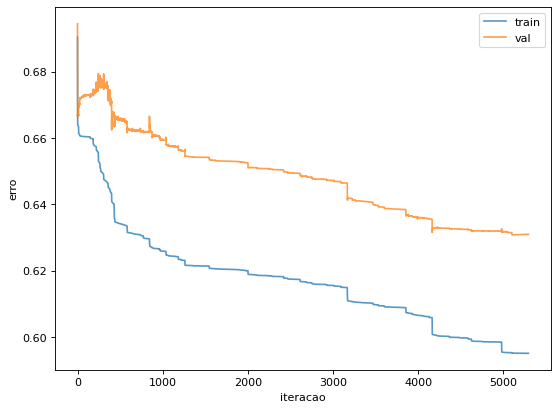

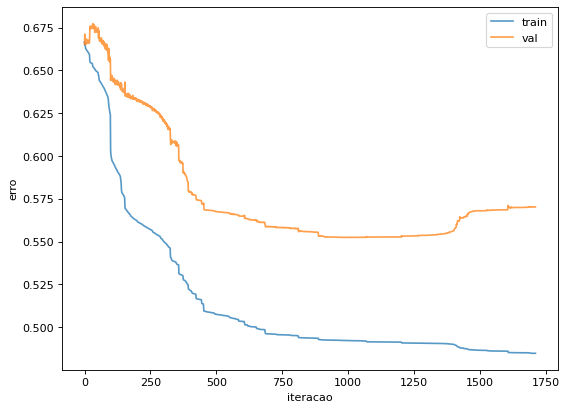

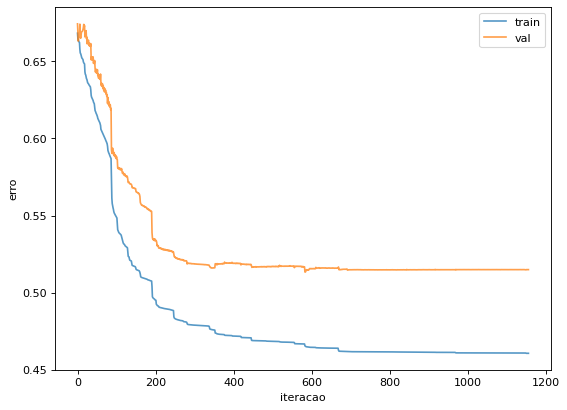

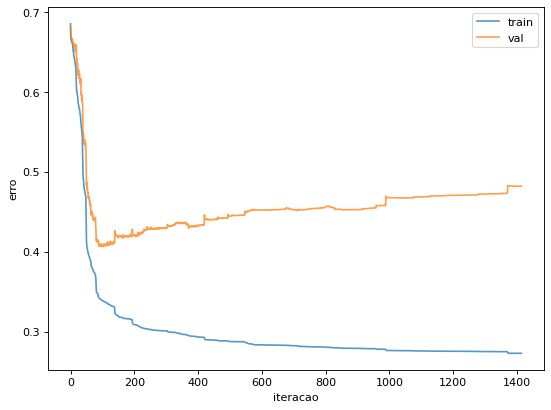

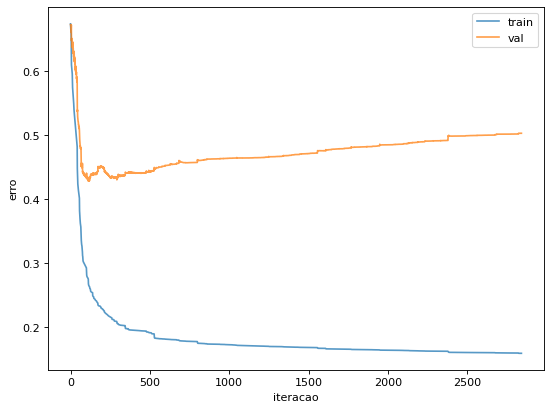

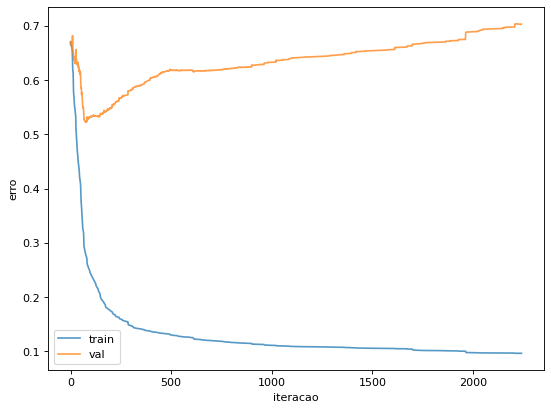

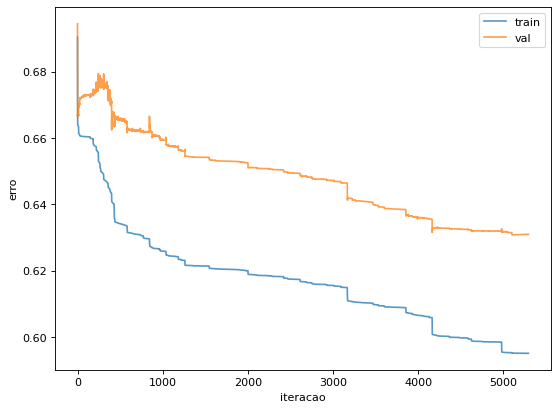

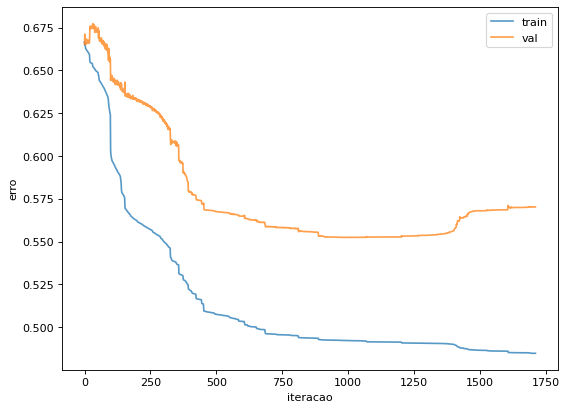

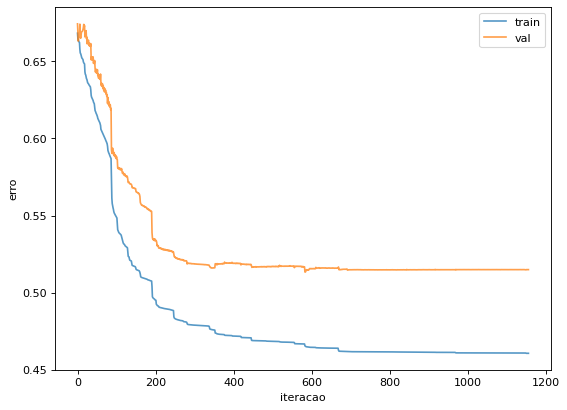

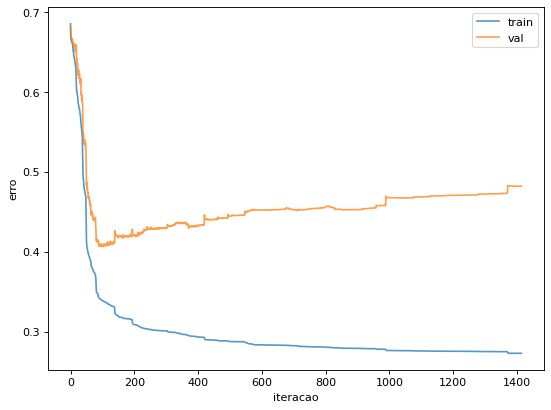

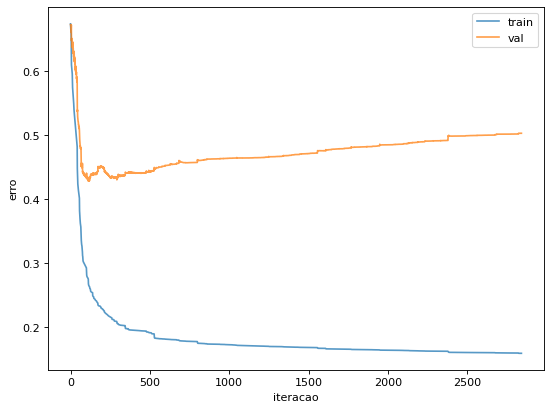

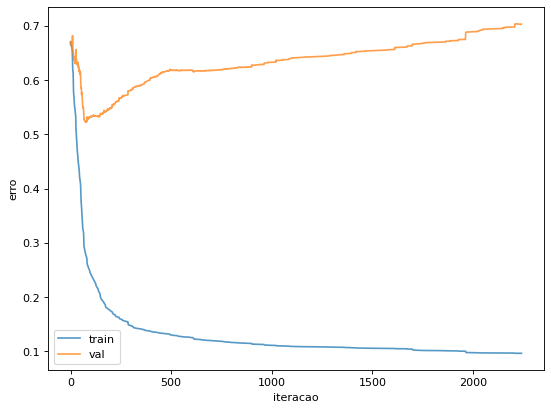

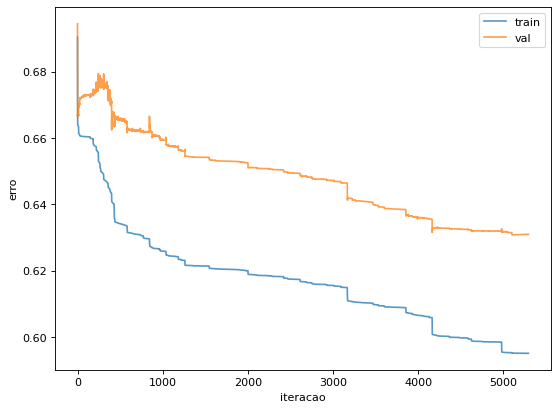

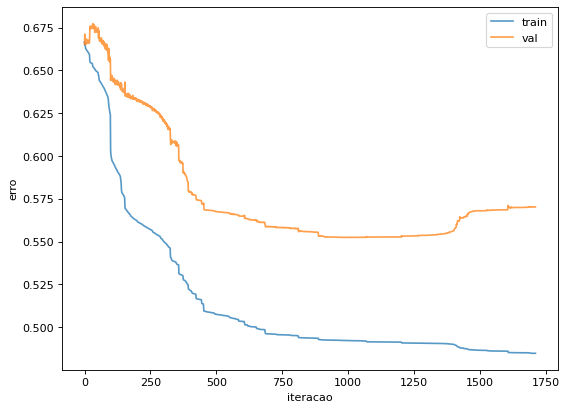

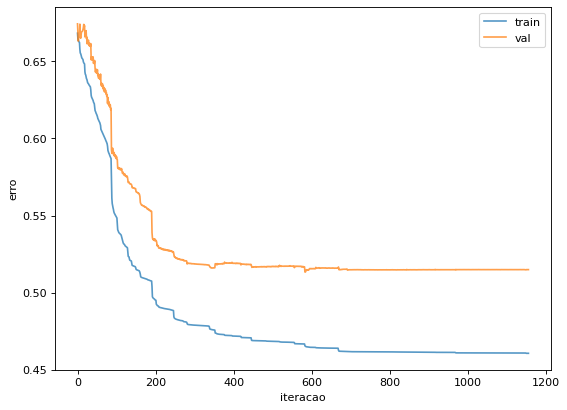

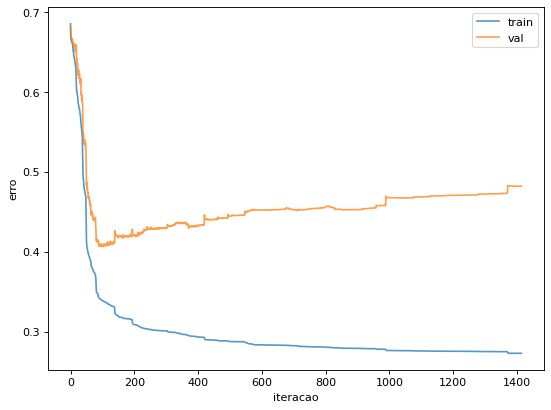

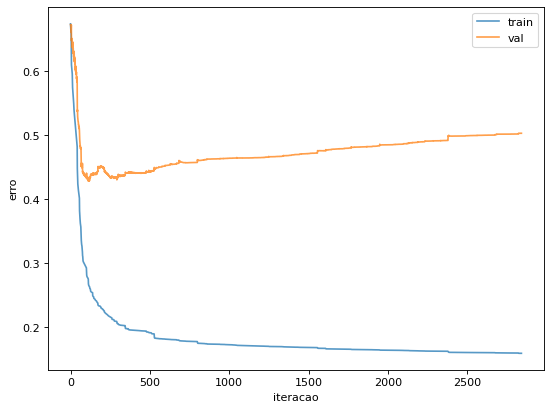

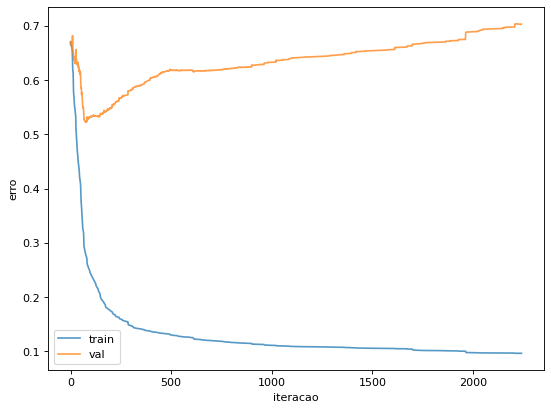

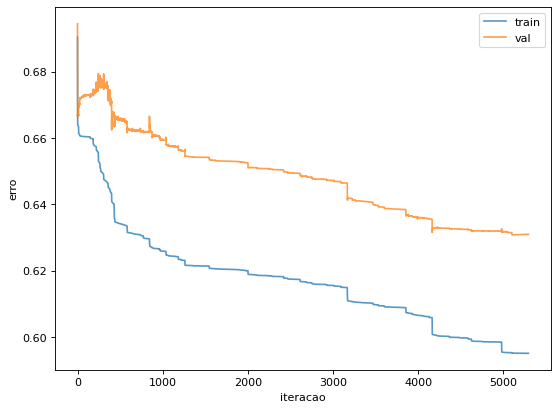

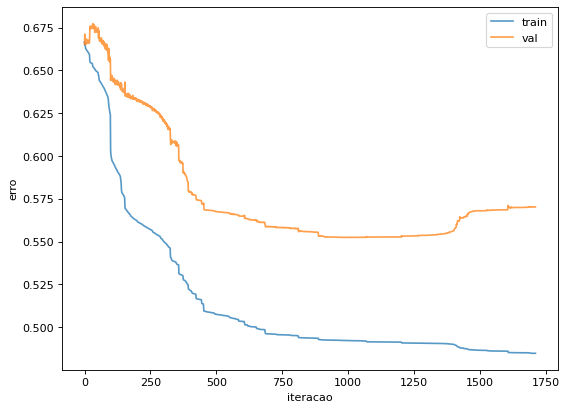

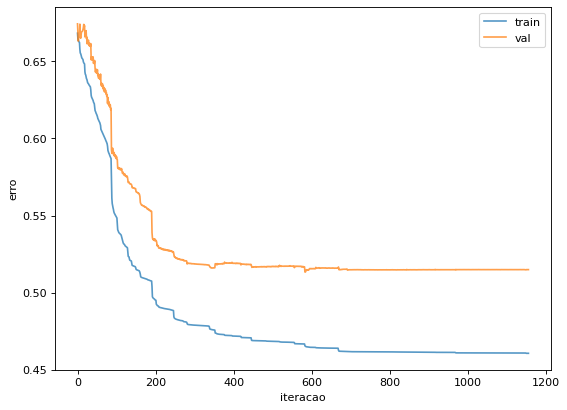

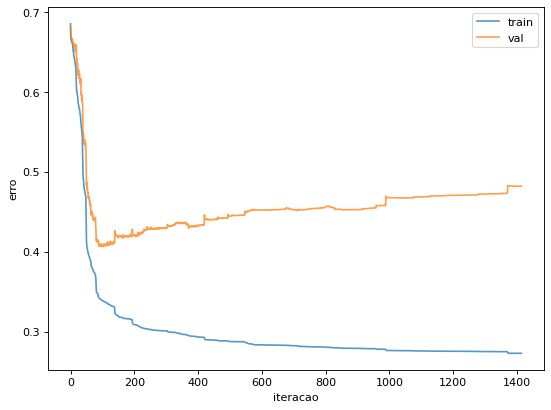

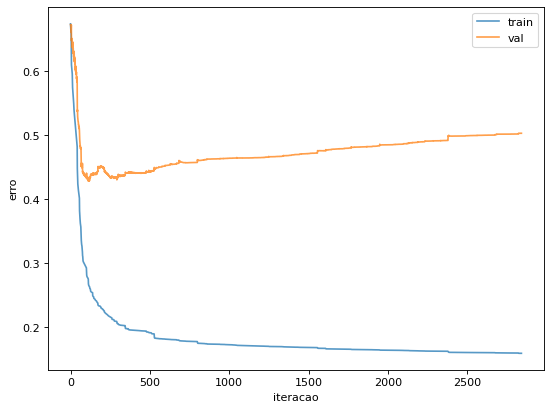

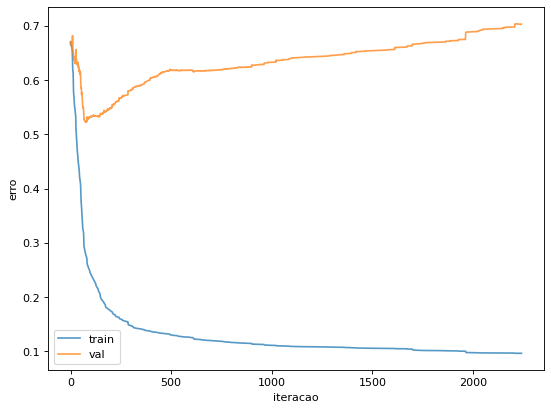

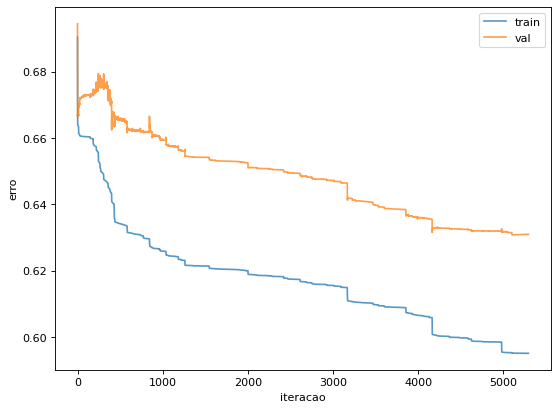

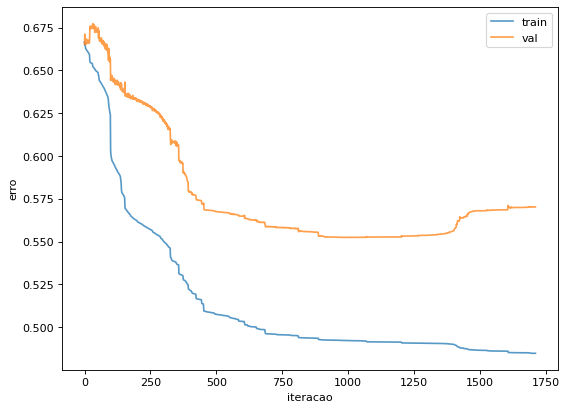

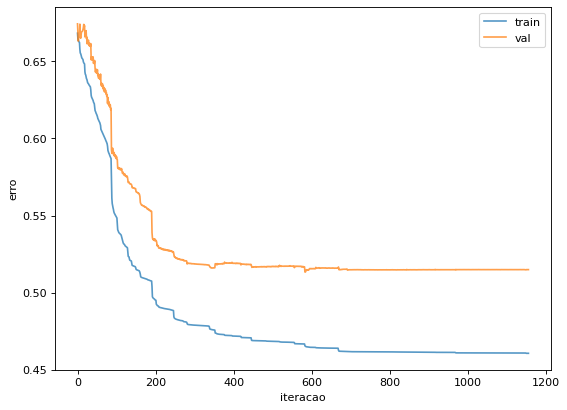

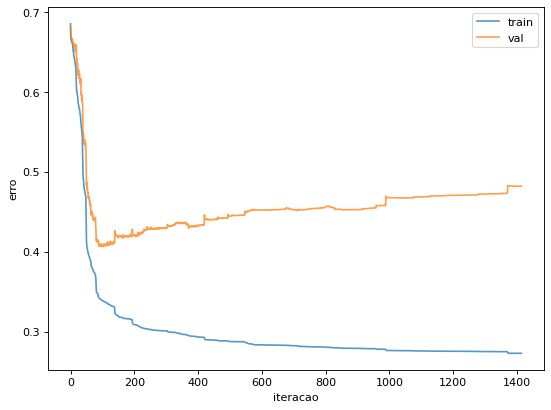

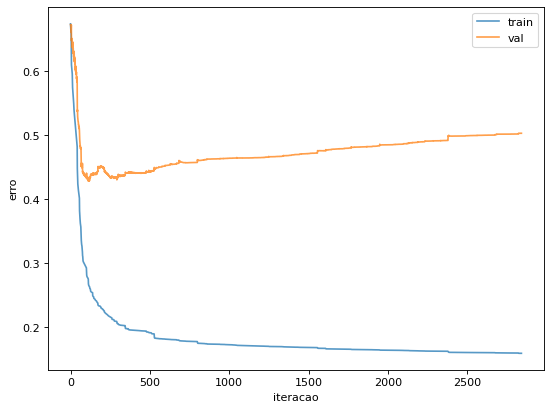

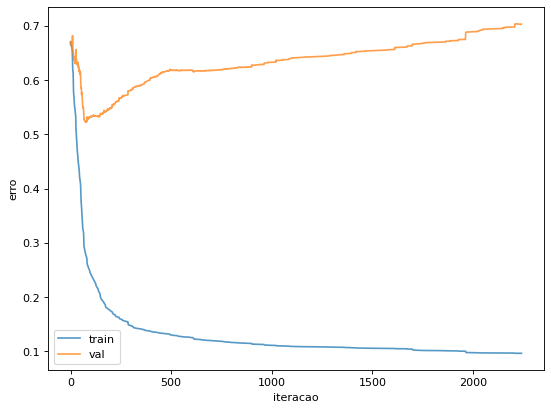

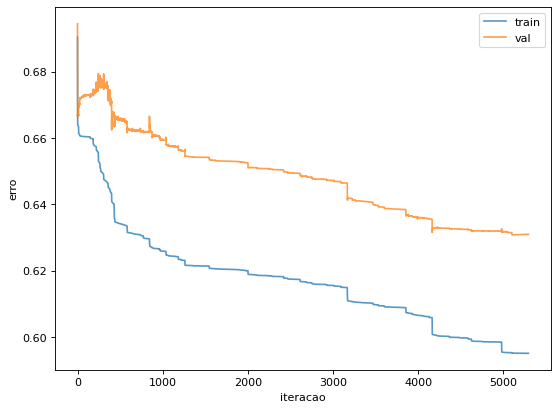

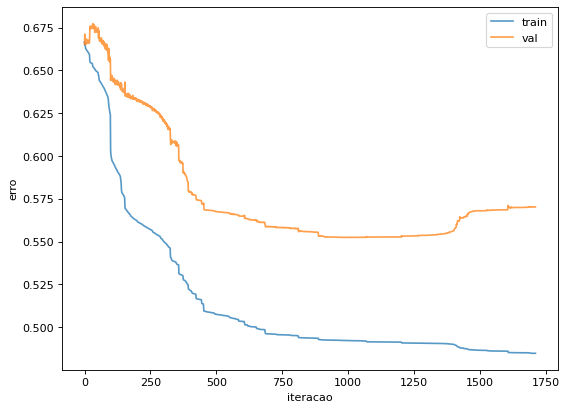

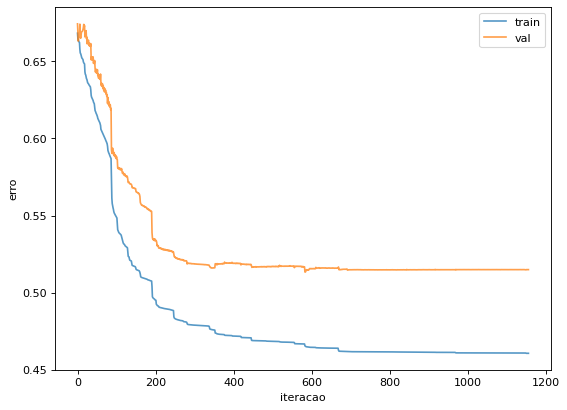

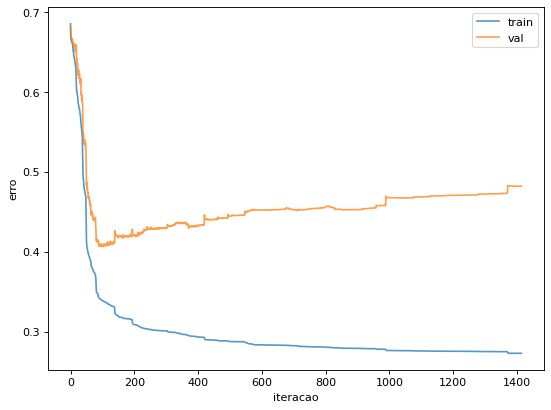

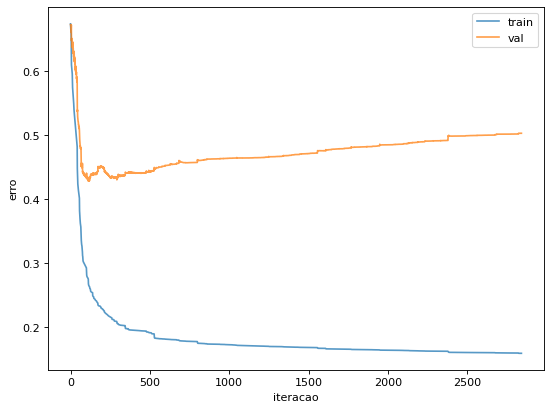

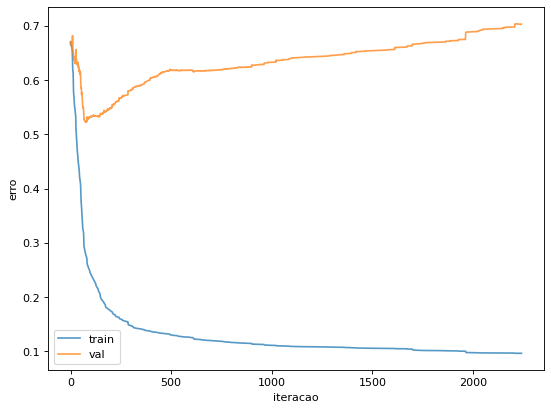

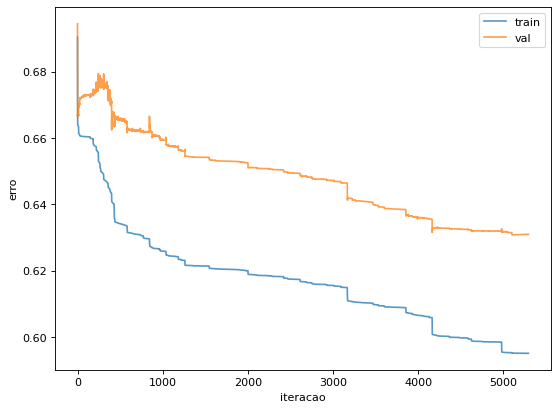

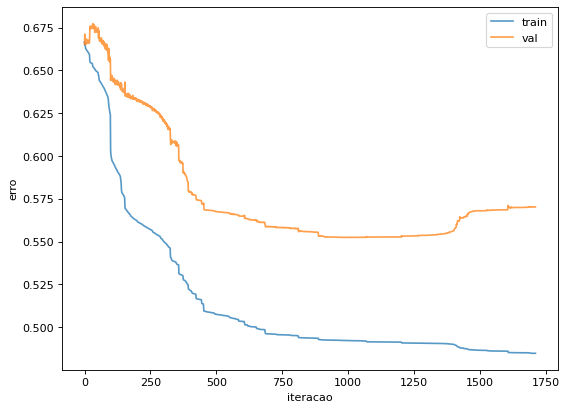

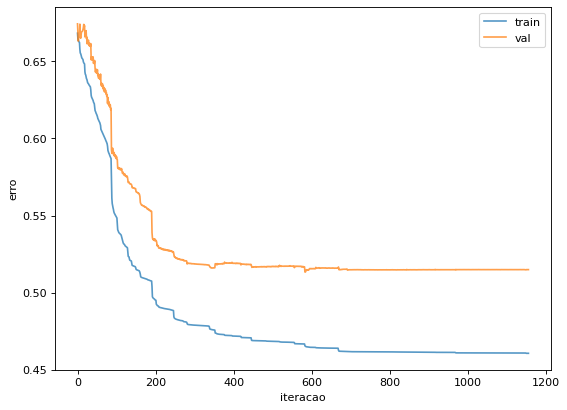

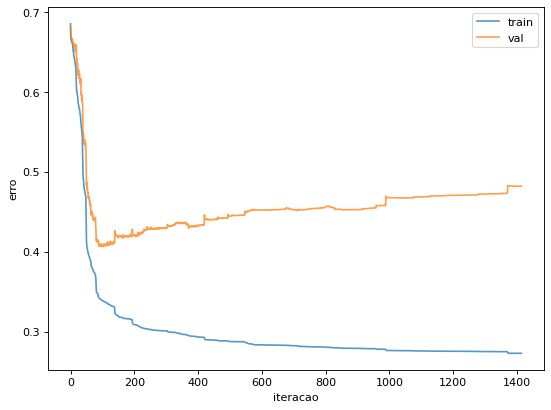

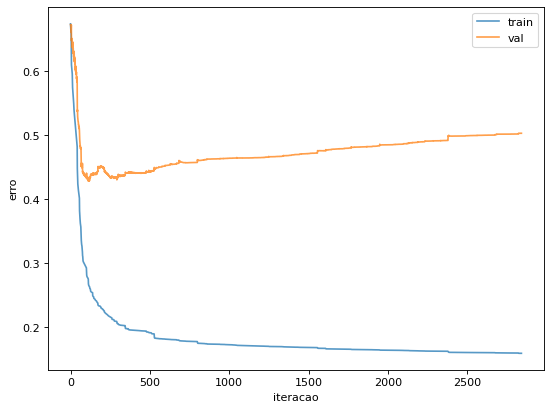

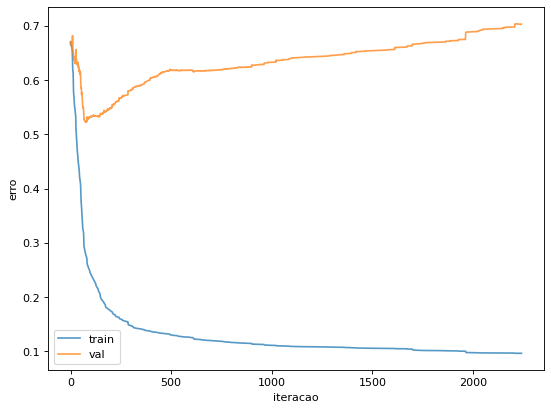

In [ ]:
# testano para valores de h
h_values = [5,10,15,20,25,50,100]
pca_n_values = [5,10,15,30,60,90]

for h in h_values:
  for pca_n in pca_n_values:
    print('h:{} n_components:{}'.format(h, pca_n))
    test_pipeline_rna_b(X_all, y_all, h, pca_n)

In [ ]:
class PipeLine_wPCA(PipeLine):

  def __init__(self, model, X, y,  h_values=[5], n_components_PCA = 30, hold_out_perc=0.8, rounds=2, n_folds=5, seed=10):
    super().__init__(model, X, y,h_values=h_values, hold_out_perc=hold_out_perc, rounds=rounds, n_folds=n_folds, seed=seed)
    self.n_components_PCA =n_components_PCA
  
  def hold_out_n_round(self):
    self.accuracies_df = pd.DataFrame()
    final_results = {}

    for round in range(0,self.rounds):
      print('round:',round)
      perm = np.random.permutation(self.X.index)
      X_shuffle= self.X.copy().reindex(perm).copy()
      y_shuffle= self.y.copy().reindex(perm).copy()

      XTR = X_shuffle.iloc[:int(self.m*self.hold_out_perc),:]
      XTST = X_shuffle.iloc[int(self.m*self.hold_out_perc):,:]

      YTR = y_shuffle.iloc[:int(self.m*self.hold_out_perc),:]
      YTST = y_shuffle.iloc[int(self.m*self.hold_out_perc):,:]

      XTR_NORM = (XTR - XTR.mean())/ XTR.std()
      XTST_NORM = (XTST - XTR.mean())/ XTR.std()

      pca = PCA(n_components=self.n_components_PCA)
      pca.fit(XTR_NORM)

      XTR_PCA = pd.DataFrame(pca.transform(XTR_NORM))
      XTST_PCA = pd.DataFrame(pca.transform(XTST_NORM))

      XTR_PCA_NORM = (XTR_PCA - XTR_PCA.mean())/ XTR_PCA.std()
      XTST_PCA_NORM = (XTST_PCA - XTR_PCA.mean())/ XTR_PCA.std()

      YTR_BOOL = pd.get_dummies(YTR['32'].astype(str))
      YTST_BOOL = pd.get_dummies(YTST['32'].astype(str))

      # constroi matriz dos melhores parametros por cv e seleciona melhor parametro
      accuracies_round = self.cross_validation(XTR_PCA_NORM, YTR_BOOL)
      accuracies_round_df = pd.DataFrame(accuracies_round).reset_index()
      accuracies_round_df['h'] = accuracies_round_df['index'].apply(lambda x:x.split('_')[0])
      accuracies_round_df['round'] = round
      self.accuracies_df = self.accuracies_df.append(accuracies_round_df)
      best_h = accuracies_round_df.groupby('h').mean().sort_values(by='val',ascending=False).index[0]

      # Normaliza
      # XTR_norm = (XTR - XTR.mean())/ XTR.std()
      # XTST_norm = (XTST - XTR.mean())/ XTR.std()

      # Aplica o melhor parâmetro
      self.model.h = int(best_h)
      YPRED_TR,YPRED_TST =  self.model.fit(XTR_PCA_NORM, YTR_BOOL, XTST_PCA_NORM, YTST_BOOL)

      acc_TR,acc_TST = self.calculate_accuracy(YTR_BOOL,YPRED_TR,YTST_BOOL,YPRED_TST )

      final_results[str(round)] = (best_h, acc_TR,acc_TST)

    return final_results 

  def calculate_accuracy(self, y_train, y_train_hat, y_val, y_val_hat, threshold=.5):
    # Adaptada para problema multiclasse
    # ytr_bool = pd.get_dummies(y_train['32'].astype(str))
    # yval_bool = pd.get_dummies(y_val['32'].astype(str))

    acc_train = (pd.DataFrame(y_train_hat, columns = y_train.columns).idxmax(axis=1).reset_index(drop=True) == y_train.idxmax(axis=1).reset_index(drop=True)).mean()
    acc_val = (pd.DataFrame(y_val_hat, columns = y_train.columns).idxmax(axis=1).reset_index(drop=True) == y_val.idxmax(axis=1).reset_index(drop=True)).mean()
    return (acc_train, acc_val )

round: 0
Usando 5 neuronios
nep: 1000 EQM: 0.22839312689268035 EQM_val: 0.4257970527035219 norm: 0.0004107042759770342 alfa: 20.353577017666048
nep: 2000 EQM: 0.2194241202863703 EQM_val: 0.4494277922507581 norm: 0.00020889556510656583 alfa: 19.65841046538
nep: 1000 EQM: 0.25682764858161905 EQM_val: 0.49820829671060113 norm: 0.0003716781010392531 alfa: 6.540987262234326
nep: 1000 EQM: 0.32637312393244905 EQM_val: 0.5070539077676126 norm: 0.000242115592566672 alfa: 21.905947675434376
nep: 1000 EQM: 0.26146413132386437 EQM_val: 0.39671051817747316 norm: 0.00015017105802843223 alfa: 8.179016946985765
nep: 1000 EQM: 0.27874686097089163 EQM_val: 0.47515872839923784 norm: 0.00014512652420405712 alfa: 20.859299225131693


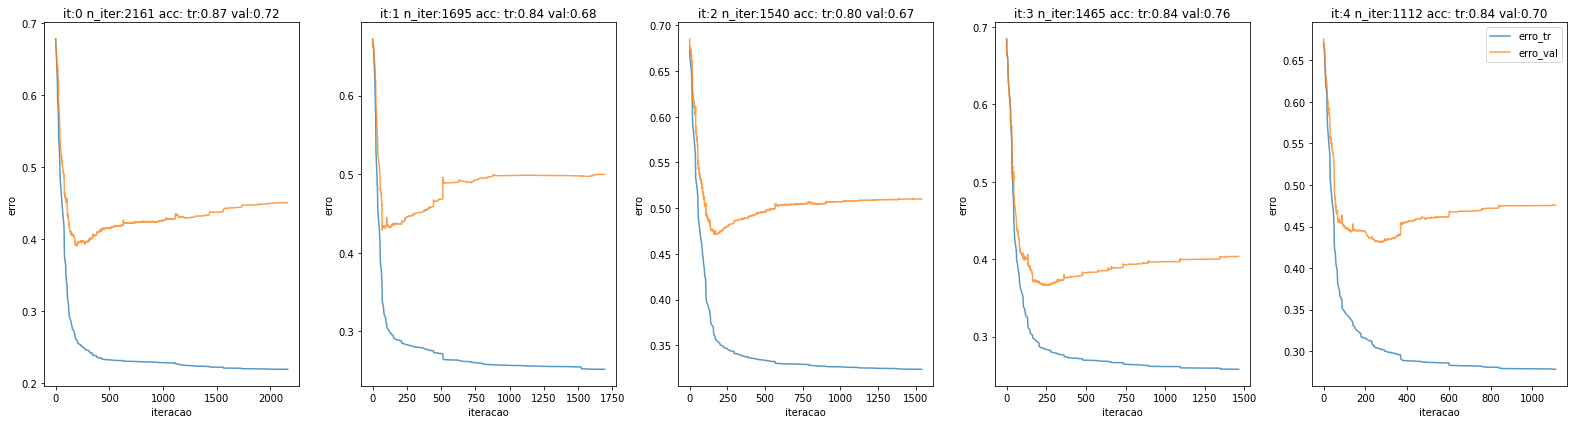

Usando 10 neuronios
nep: 1000 EQM: 0.06536590001643301 EQM_val: 0.28285844415550443 norm: 0.0007845866059334306 alfa: 2.92804855823381
nep: 2000 EQM: 0.04721618090666496 EQM_val: 0.2981788603792898 norm: 0.0004325120756528748 alfa: 6.8066899805415355
nep: 3000 EQM: 0.037693442244738286 EQM_val: 0.31682886880199856 norm: 0.00017280249626631984 alfa: 4.029298884752163
nep: 1000 EQM: 0.04067816095934194 EQM_val: 0.3234276355119121 norm: 0.0012150968095756152 alfa: 185.7309888791156
nep: 2000 EQM: 0.031753950871468276 EQM_val: 0.3534234858339162 norm: 0.00019241641899025554 alfa: 11.777135143696476
nep: 1000 EQM: 0.05209956970616138 EQM_val: 0.33592626073760024 norm: 0.0003923735360441382 alfa: 8.084116376182873
nep: 2000 EQM: 0.040709689679567555 EQM_val: 0.35369567640922217 norm: 0.00026836283912259657 alfa: 8.446986995764195
nep: 3000 EQM: 0.03703339543049696 EQM_val: 0.3651379642052729 norm: 0.00013346750824683434 alfa: 6.140663341160596
nep: 1000 EQM: 0.05887690071536496 EQM_val: 0.22

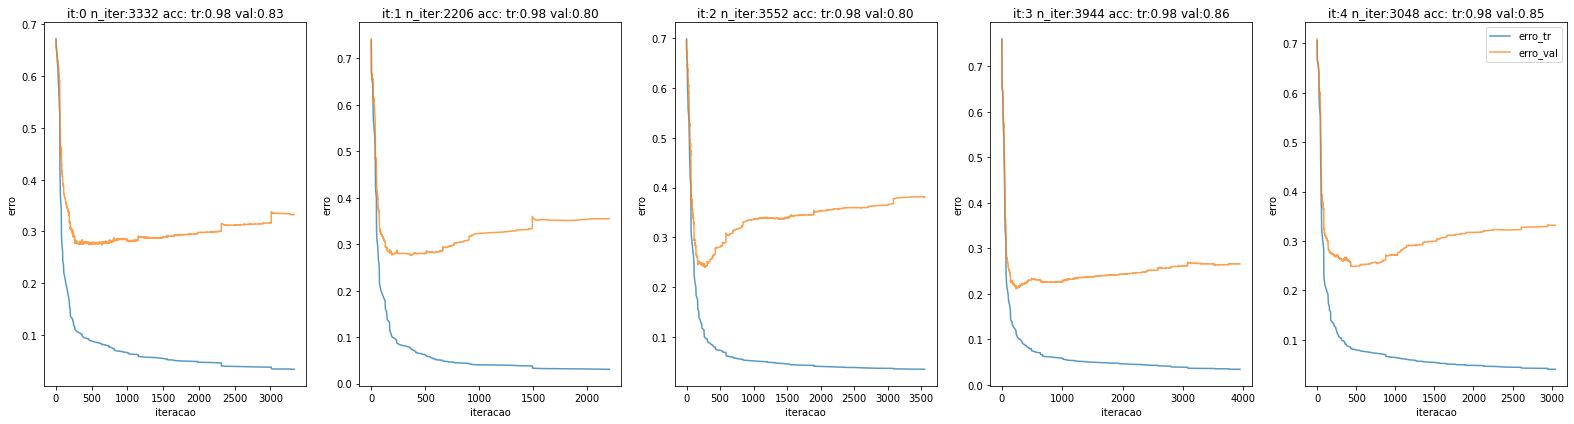

Usando 15 neuronios
nep: 1000 EQM: 0.004690616262713823 EQM_val: 0.18554005956886163 norm: 0.00019504547179528697 alfa: 29.872876467829506
nep: 1000 EQM: 0.008405303057684471 EQM_val: 0.1395045716448421 norm: 0.0007247374252905923 alfa: 17.572814578275445
nep: 1000 EQM: 0.004637039175229875 EQM_val: 0.16710418362113197 norm: 0.0003818002855786839 alfa: 81.30758624849759


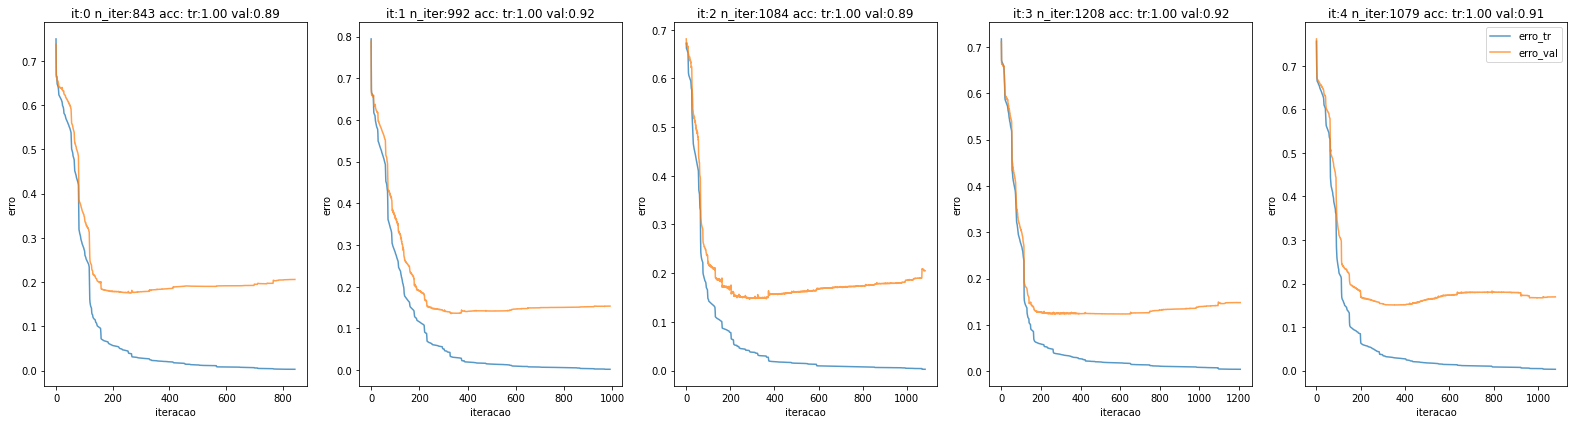

Usando 20 neuronios


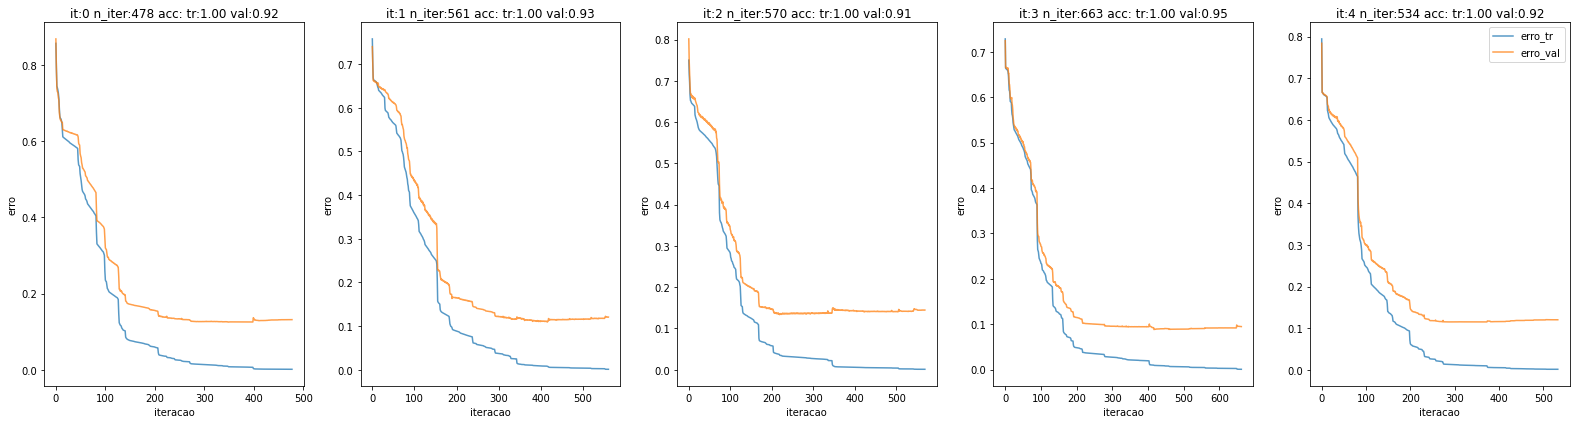

Usando 25 neuronios


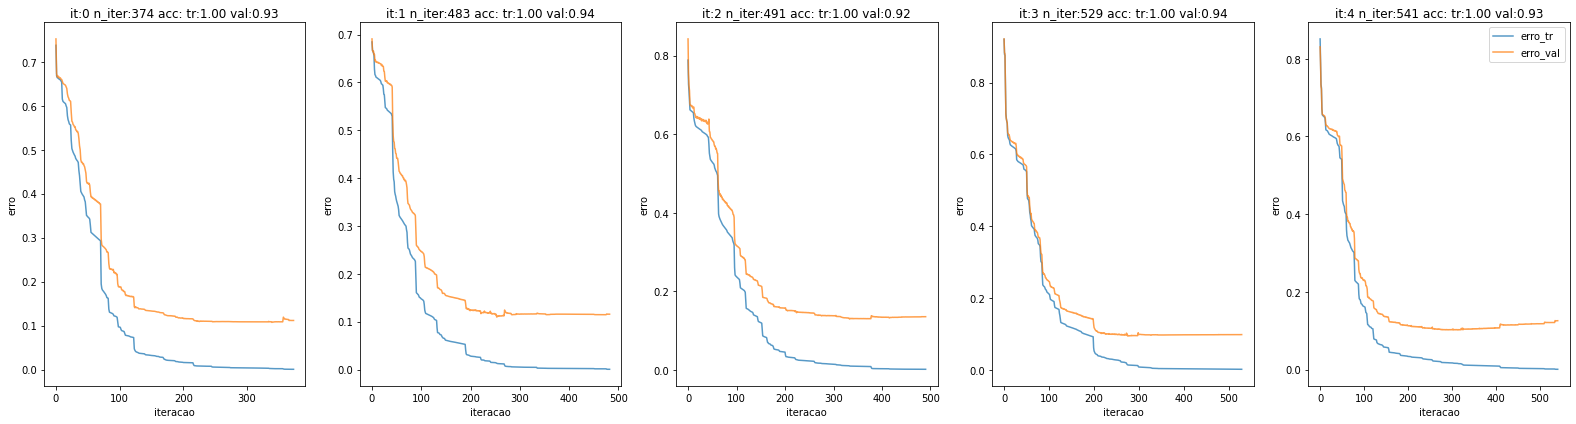

Usando 50 neuronios


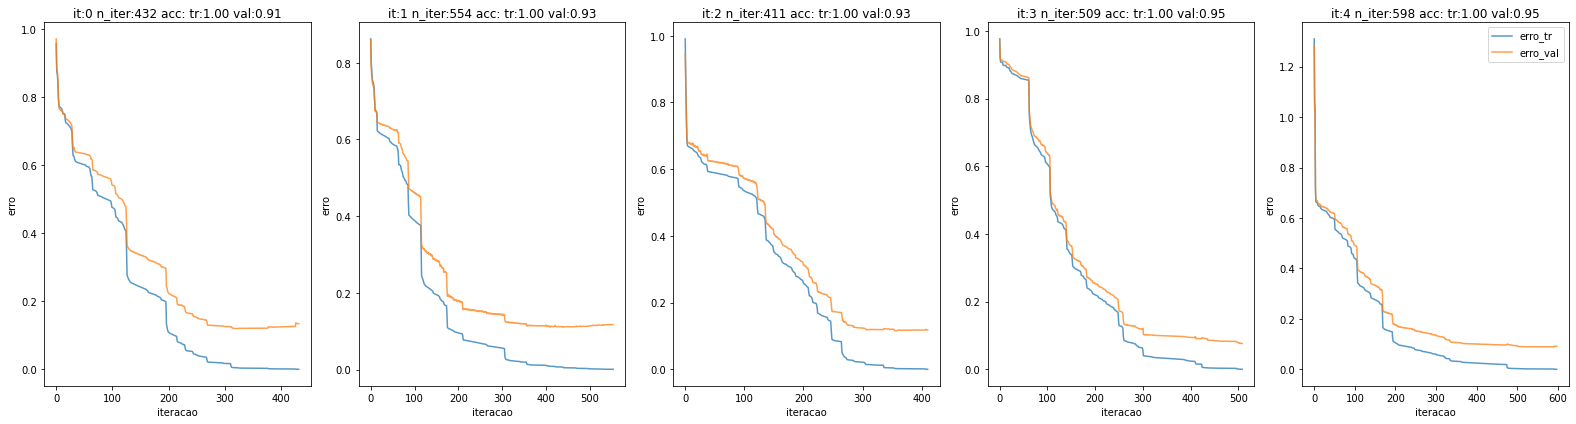

Usando 100 neuronios


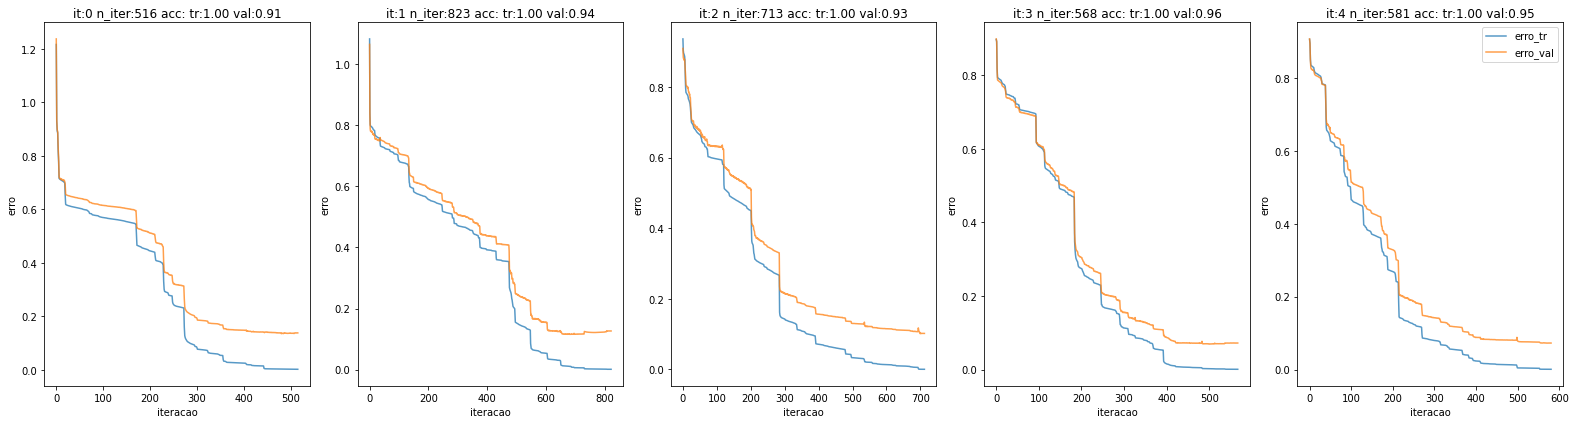

nep: 1000 EQM: 0.0031433266030432543 EQM_val: 0.12686426059315598 norm: 0.002140130181250806 alfa: 23.614436945691274
round: 1
Usando 5 neuronios
nep: 1000 EQM: 0.27556528191743174 EQM_val: 0.5222152278162774 norm: 0.0004882699180474394 alfa: 5.152898503934013
nep: 1000 EQM: 0.2921068857658691 EQM_val: 0.4966513206057601 norm: 0.00022935634394186252 alfa: 18.19431012091723
nep: 1000 EQM: 0.32154320183306095 EQM_val: 0.5082860542356656 norm: 0.0004804481853203341 alfa: 7.735314520696884
nep: 2000 EQM: 0.3134574666386249 EQM_val: 0.5345935323252273 norm: 0.0002766056903675878 alfa: 3.5115006442380787
nep: 1000 EQM: 0.2938543055069597 EQM_val: 0.46865363785179215 norm: 0.0002555448351727019 alfa: 16.03720309322681
nep: 2000 EQM: 0.2839843451703485 EQM_val: 0.47082399199693914 norm: 0.00012054915133888314 alfa: 5.149936776835933
nep: 1000 EQM: 0.2941614640771103 EQM_val: 0.46899493655208335 norm: 0.0003065744082692275 alfa: 5.087370967841735
nep: 2000 EQM: 0.2875014415680934 EQM_val: 0.483

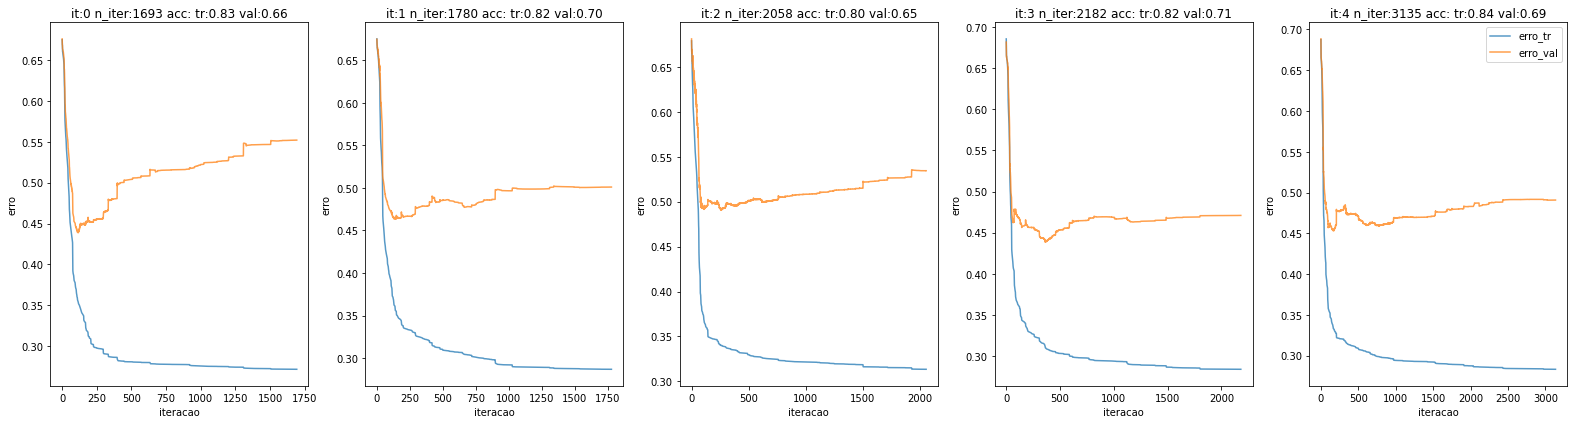

Usando 10 neuronios
nep: 1000 EQM: 0.04143734615673603 EQM_val: 0.2677865958386225 norm: 0.0005828661490990903 alfa: 7.184394866340332
nep: 2000 EQM: 0.03208882172435523 EQM_val: 0.2906205675088115 norm: 0.0002524351437867238 alfa: 11.421636815331826
nep: 1000 EQM: 0.06999802666542687 EQM_val: 0.26658683760693186 norm: 0.0007406603903836099 alfa: 20.760437331220473
nep: 2000 EQM: 0.05095697424915989 EQM_val: 0.2706606820592297 norm: 0.00021689746898972118 alfa: 4.549252873633219
nep: 3000 EQM: 0.04641395051204973 EQM_val: 0.2831305768579531 norm: 0.00020868362059254993 alfa: 4.774892066671808
nep: 4000 EQM: 0.043854514101488946 EQM_val: 0.29285228781971423 norm: 0.00011446266353060243 alfa: 3.8278232415107247
nep: 1000 EQM: 0.044066931199971585 EQM_val: 0.23719844164884596 norm: 0.0005287694436668623 alfa: 12.885057427910844
nep: 2000 EQM: 0.032842719822386846 EQM_val: 0.2790473977692379 norm: 0.0001309577152908654 alfa: 7.8197172468547045
nep: 1000 EQM: 0.0718576515986364 EQM_val: 0.2

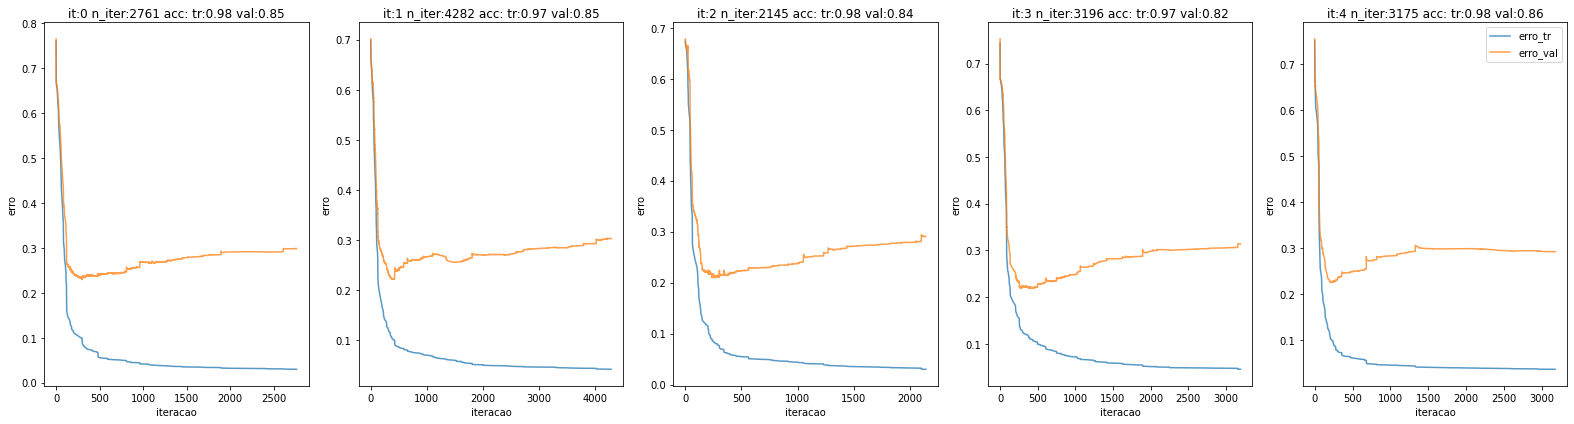

Usando 15 neuronios
nep: 1000 EQM: 0.004738611207835702 EQM_val: 0.23451138877876163 norm: 0.00036206485796606624 alfa: 81.87516501452913
nep: 1000 EQM: 0.004367659532678281 EQM_val: 0.20166933746927174 norm: 0.00010868297958478316 alfa: 24.280562939664144


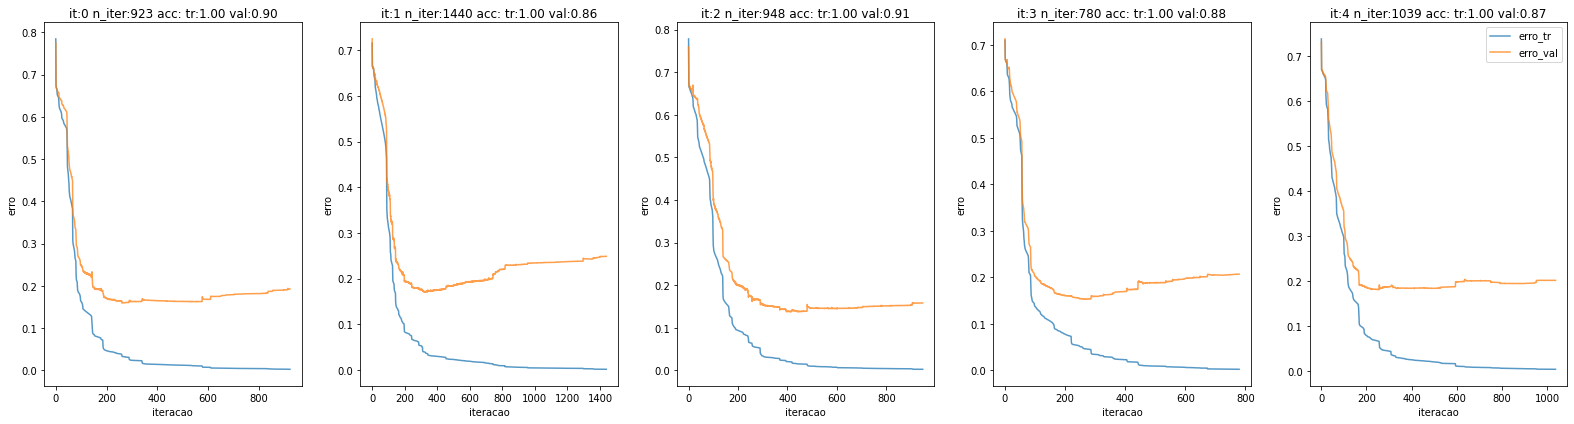

Usando 20 neuronios


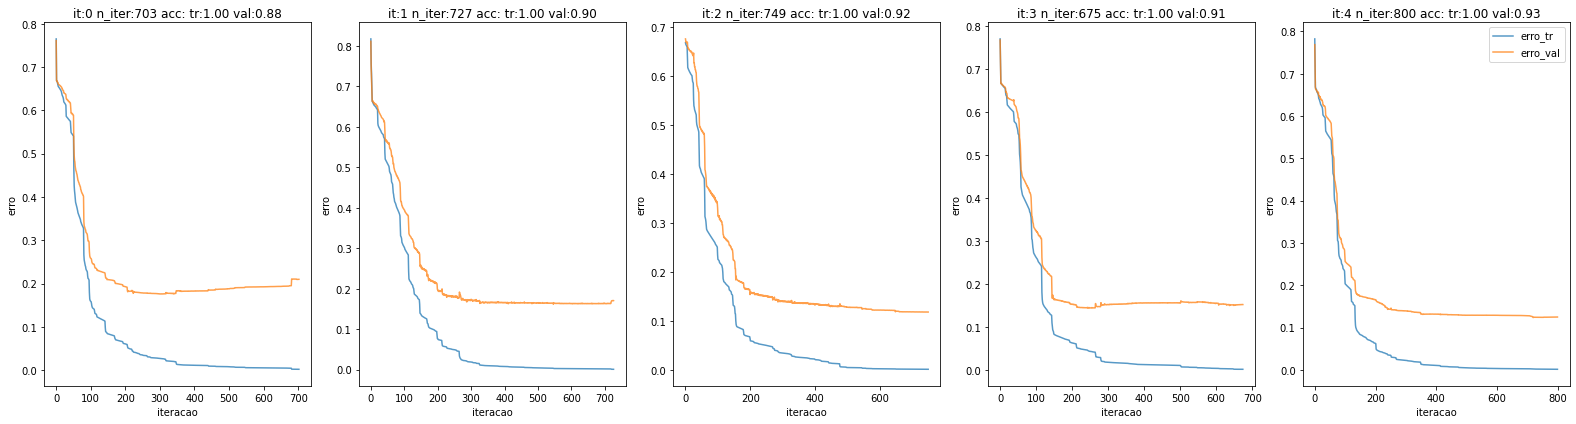

Usando 25 neuronios


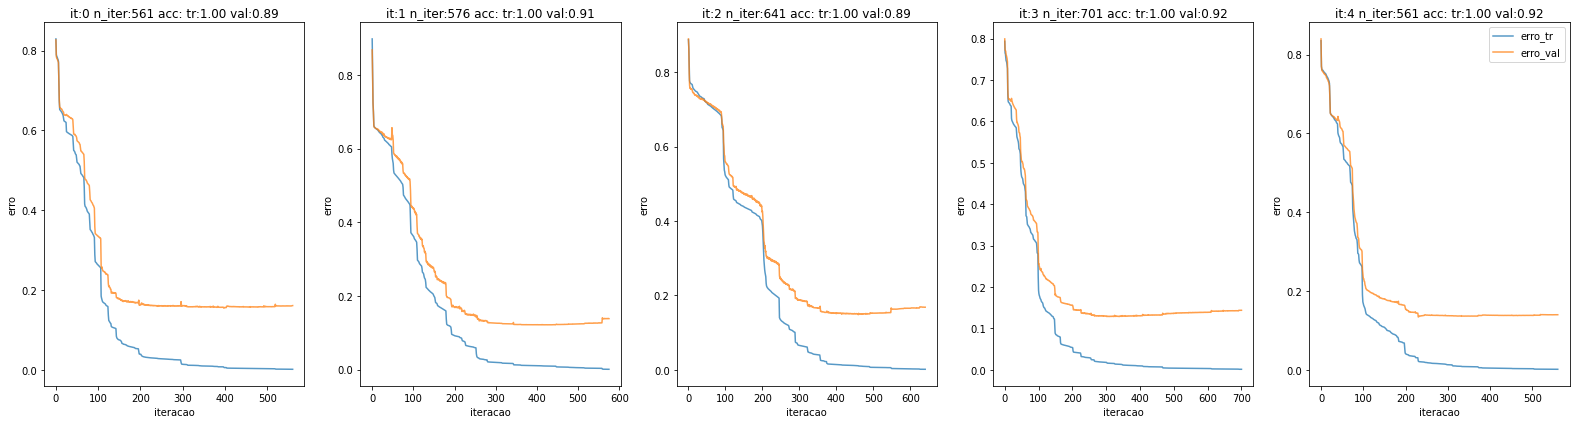

Usando 50 neuronios


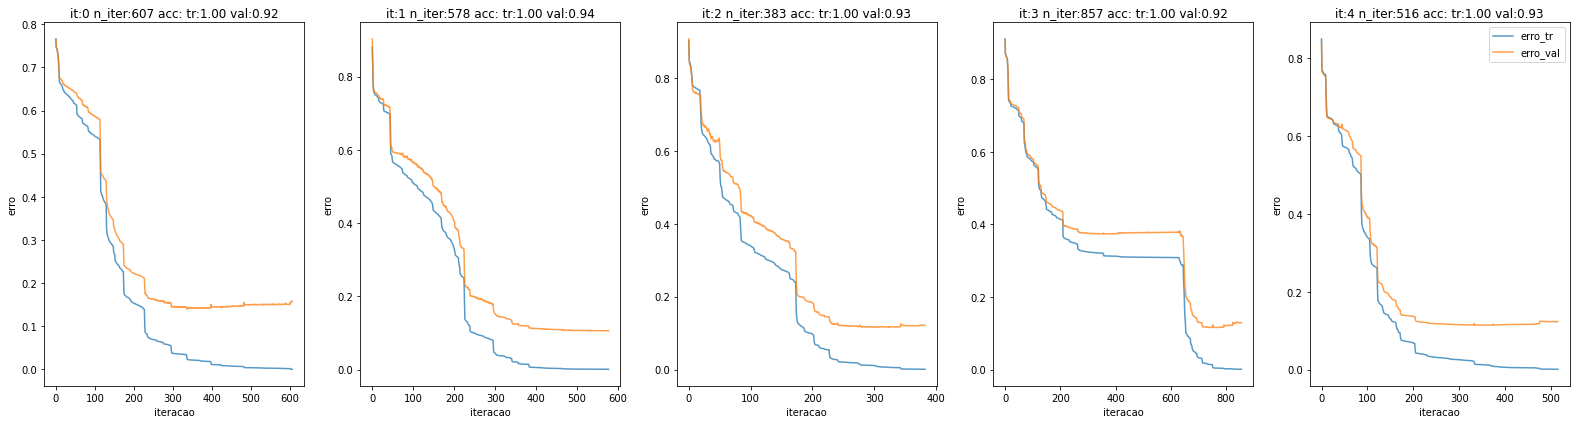

Usando 100 neuronios
nep: 1000 EQM: 0.007335961178706431 EQM_val: 0.1124830008411233 norm: 0.001265070387894393 alfa: 57.501235136452166
nep: 1000 EQM: 0.0064478589116721136 EQM_val: 0.10123903359090802 norm: 0.0009847719546676207 alfa: 12.486464830685343


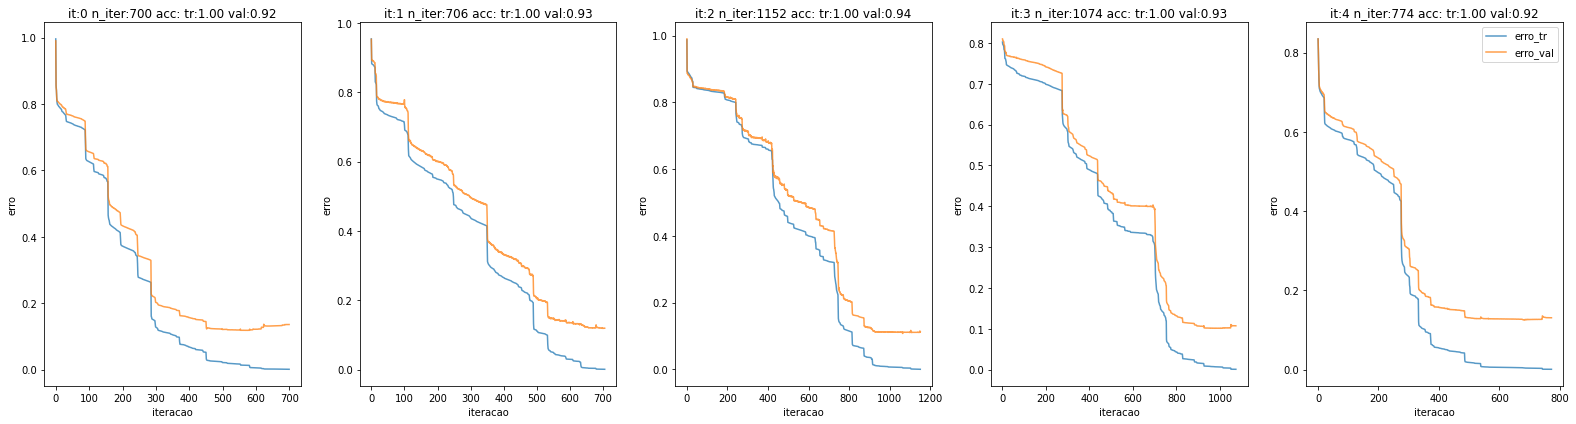

round: 2
Usando 5 neuronios
nep: 1000 EQM: 0.2719704118762696 EQM_val: 0.44460485722366816 norm: 0.000937855741025164 alfa: 157.68081894975467
nep: 2000 EQM: 0.266090652324738 EQM_val: 0.4537563652430263 norm: 0.0003254528457276336 alfa: 21.933945569547248
nep: 1000 EQM: 0.24311166282398183 EQM_val: 0.5078310121527321 norm: 0.0003785249094214442 alfa: 35.705298782874976
nep: 2000 EQM: 0.23491705302453314 EQM_val: 0.5222351015987838 norm: 0.00018714504948704535 alfa: 23.784060900095856
nep: 1000 EQM: 0.26869990110733766 EQM_val: 0.5556822896901249 norm: 0.00022346207774921734 alfa: 16.8366328365272
nep: 1000 EQM: 0.26436059039579907 EQM_val: 0.44781621487474765 norm: 0.00037472323731960297 alfa: 11.836298268194929
nep: 1000 EQM: 0.2745046605704759 EQM_val: 0.5021082404641771 norm: 0.0003997548038148818 alfa: 13.008864015918295


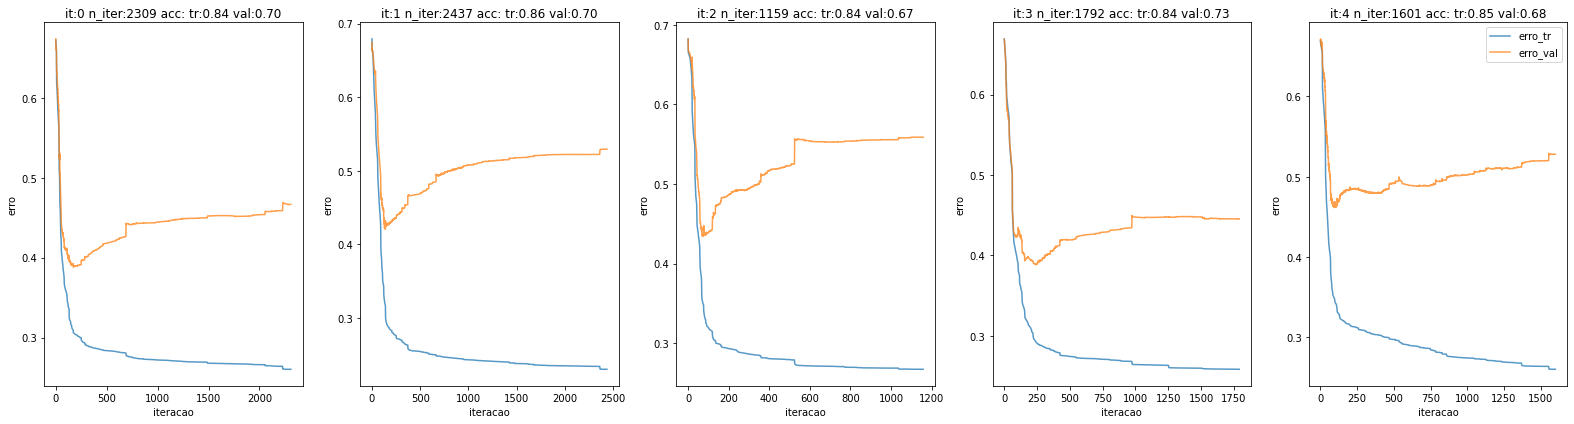

Usando 10 neuronios
nep: 1000 EQM: 0.04286434155646949 EQM_val: 0.25204148257624404 norm: 0.0004417633439911615 alfa: 5.819468604354186
nep: 2000 EQM: 0.03309217407338988 EQM_val: 0.2869759236569487 norm: 0.00041420487603866055 alfa: 5.788845002286756
nep: 3000 EQM: 0.02719997725546595 EQM_val: 0.2993088819448444 norm: 0.0006024504821792277 alfa: 228.76819773336658
nep: 1000 EQM: 0.04160961725983696 EQM_val: 0.2819360884589822 norm: 0.000595030474706472 alfa: 12.95333248231864
nep: 2000 EQM: 0.03089172642184871 EQM_val: 0.3020062788502927 norm: 0.00016569634302860417 alfa: 4.512020331342241
nep: 3000 EQM: 0.02853380247319767 EQM_val: 0.29611867225280336 norm: 0.0002507523392110382 alfa: 14.490328378537429
nep: 4000 EQM: 0.02669380010869855 EQM_val: 0.2946064893373828 norm: 0.0007181160076316954 alfa: 92.53902031060602
nep: 1000 EQM: 0.041094568026767184 EQM_val: 0.26922759964649096 norm: 0.00047102418689608775 alfa: 16.093314143146998
nep: 2000 EQM: 0.02828758356458348 EQM_val: 0.26943

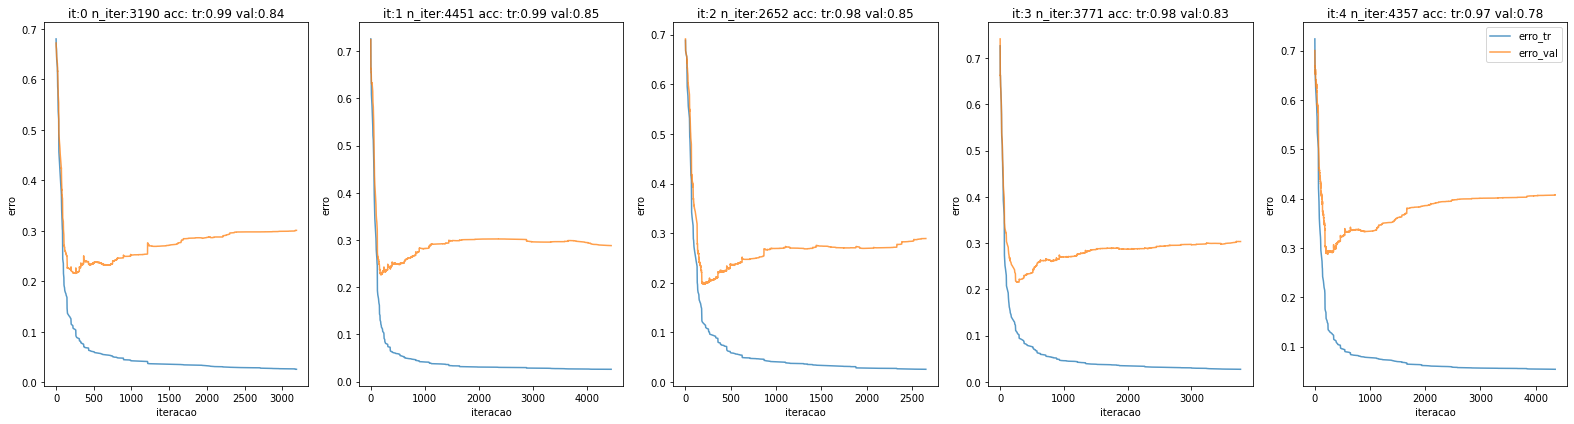

Usando 15 neuronios
nep: 1000 EQM: 0.003597657882836375 EQM_val: 0.16809219031984554 norm: 0.00010427000023216904 alfa: 18.430313125319024
nep: 1000 EQM: 0.004039819228143246 EQM_val: 0.20259997638557894 norm: 0.00018584989749162057 alfa: 43.91257166442496
nep: 1000 EQM: 0.005613418564342643 EQM_val: 0.18559789409630587 norm: 0.00024667767460018024 alfa: 62.40760896273303


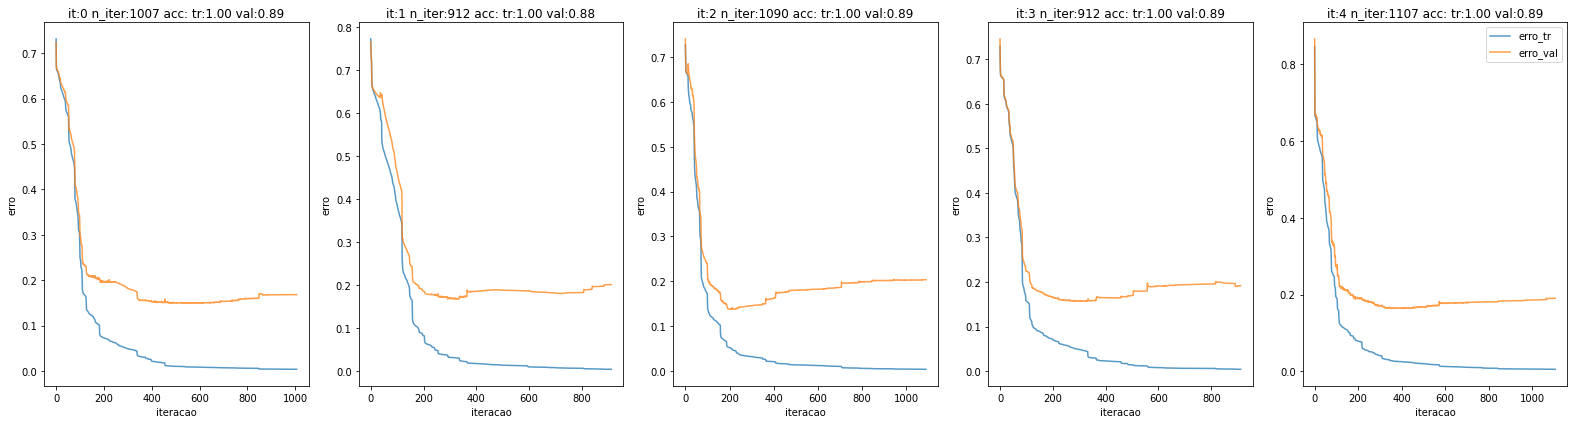

Usando 20 neuronios


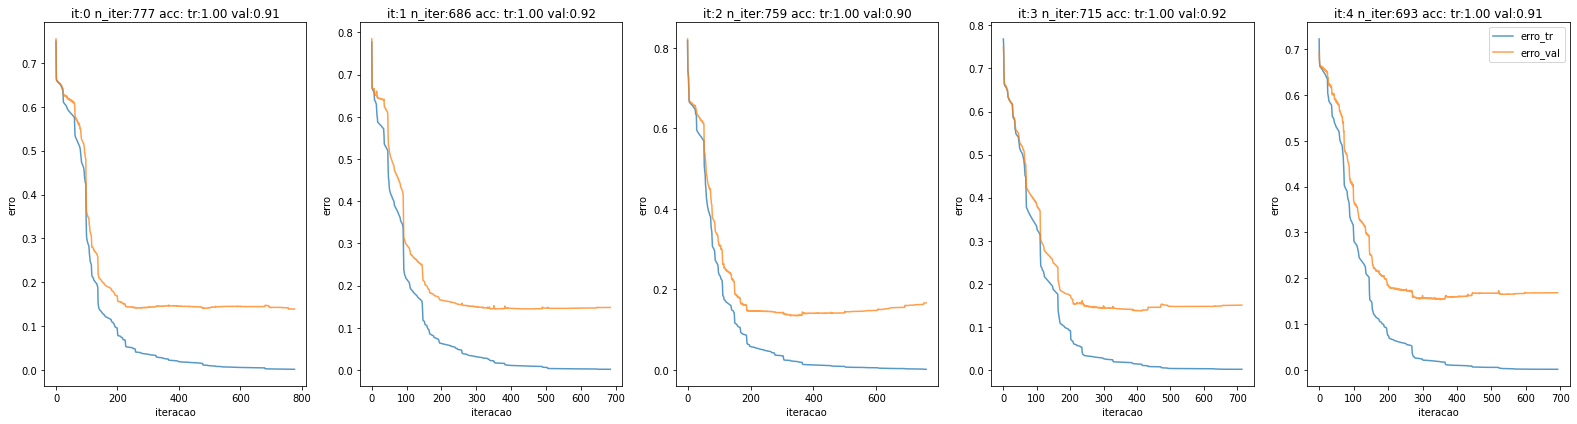

Usando 25 neuronios


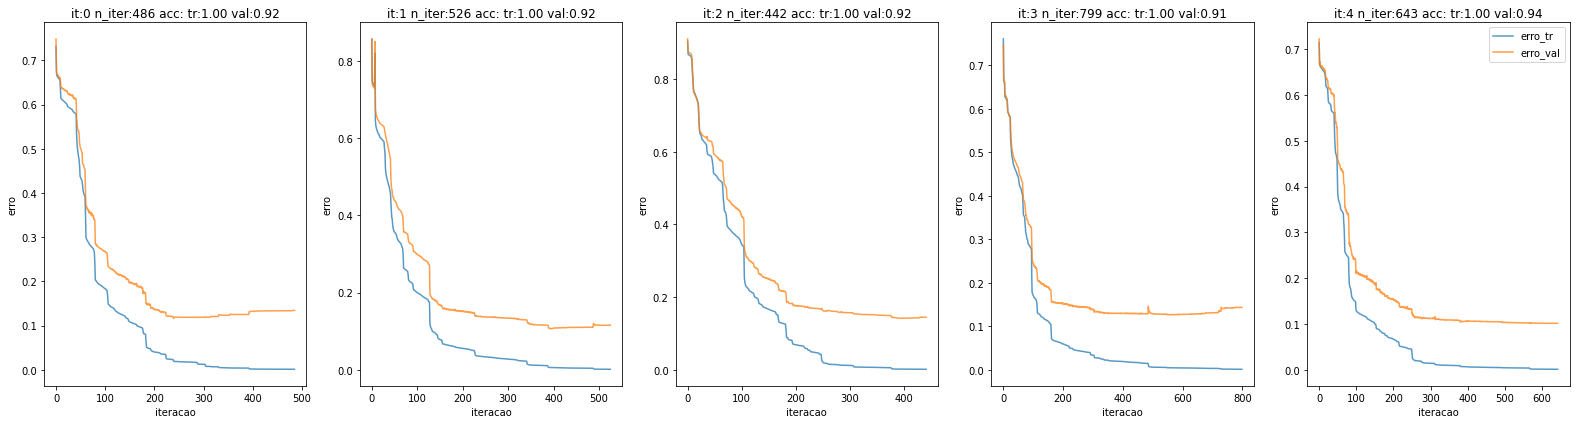

Usando 50 neuronios


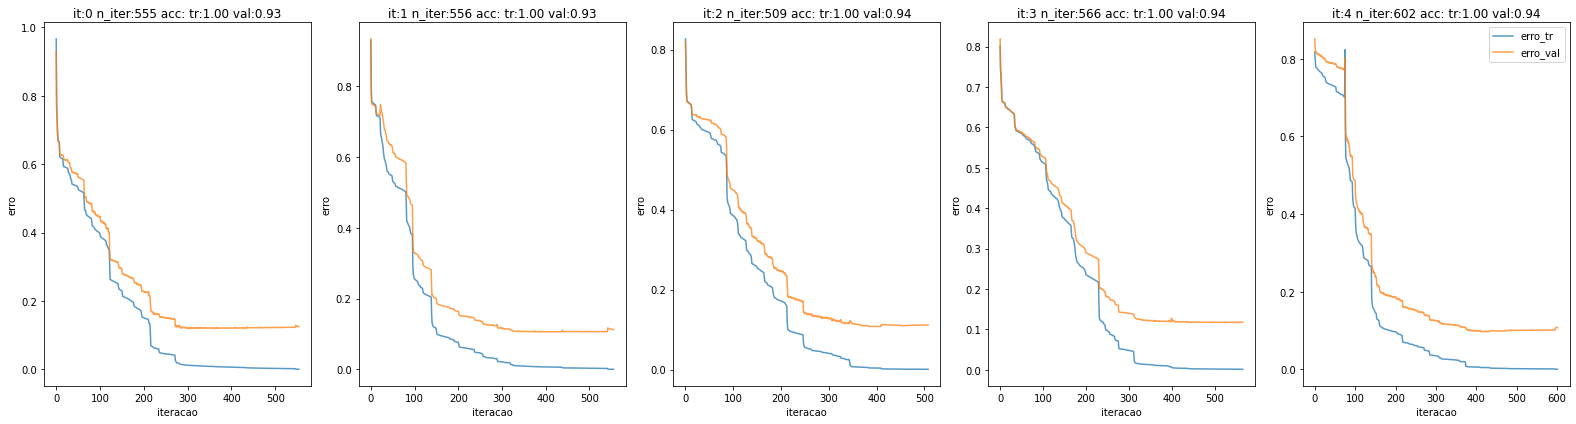

Usando 100 neuronios


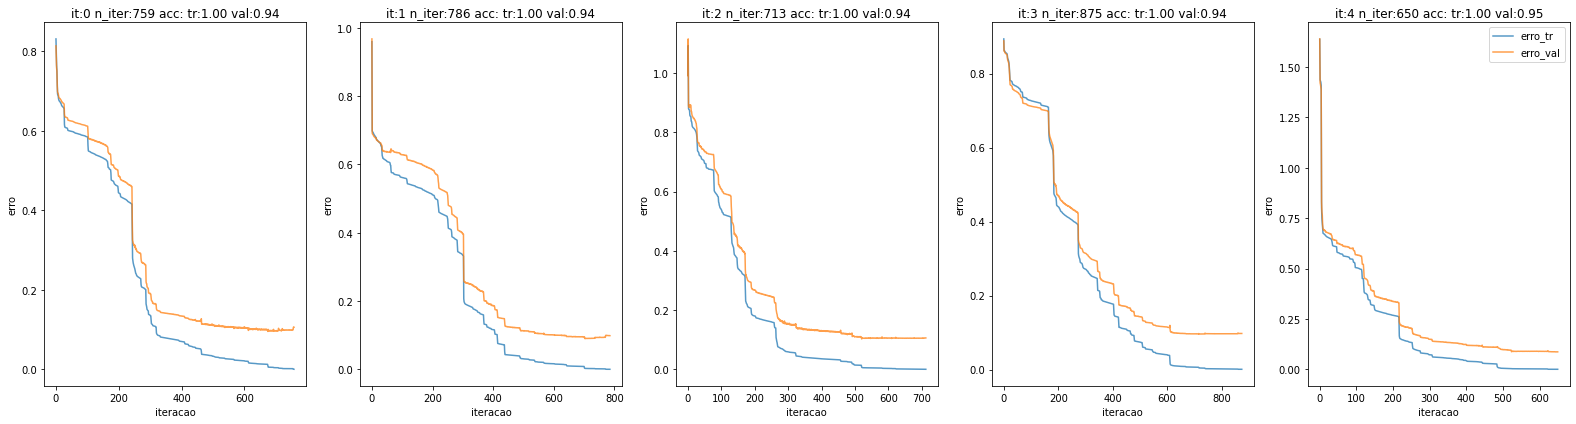

round: 3
Usando 5 neuronios
nep: 1000 EQM: 0.25725882965808355 EQM_val: 0.47540310661683893 norm: 0.0008508304429167806 alfa: 93.89989192021687
nep: 1000 EQM: 0.2583452347032022 EQM_val: 0.4621719964014085 norm: 0.00013386635394842348 alfa: 11.200988998486132
nep: 1000 EQM: 0.22839808295246516 EQM_val: 0.49271254798160463 norm: 0.0002754676358473788 alfa: 19.46923675604021
nep: 1000 EQM: 0.26910907647189775 EQM_val: 0.5322747572366675 norm: 0.0001666379848279999 alfa: 7.459466734940918
nep: 1000 EQM: 0.3233571033881025 EQM_val: 0.5589931589009114 norm: 0.0003349552374017198 alfa: 36.46782820321198


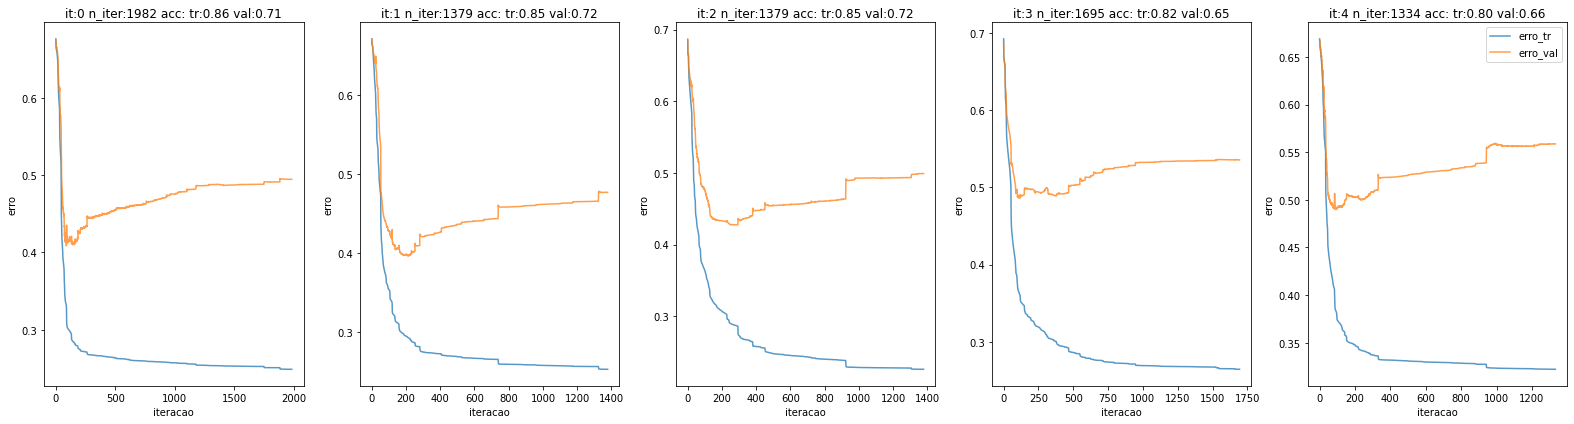

Usando 10 neuronios
nep: 1000 EQM: 0.03491747614327718 EQM_val: 0.30378488175268714 norm: 0.00033744665258863307 alfa: 7.455389906068172
nep: 2000 EQM: 0.022970621034141703 EQM_val: 0.34796577193079237 norm: 0.00017862849694609163 alfa: 14.559483582904317
nep: 1000 EQM: 0.051641752745590803 EQM_val: 0.24185625340103017 norm: 0.0014342511324583755 alfa: 20.634367825127946
nep: 2000 EQM: 0.03925277690181432 EQM_val: 0.24650699050520583 norm: 0.00033334511238715235 alfa: 19.733383700616805
nep: 3000 EQM: 0.033196281409355016 EQM_val: 0.25207952382916565 norm: 0.0013090440439316611 alfa: 849.3232052674509
nep: 1000 EQM: 0.042056227827414396 EQM_val: 0.24912806146996258 norm: 0.000793722416573855 alfa: 12.44758527586561
nep: 2000 EQM: 0.027684586674426477 EQM_val: 0.3079089875937493 norm: 0.0003649938828262294 alfa: 62.11150439224493
nep: 1000 EQM: 0.06405306772985751 EQM_val: 0.24869251936525177 norm: 0.0007287723660353175 alfa: 4.690434014489254
nep: 2000 EQM: 0.04512973342083054 EQM_val:

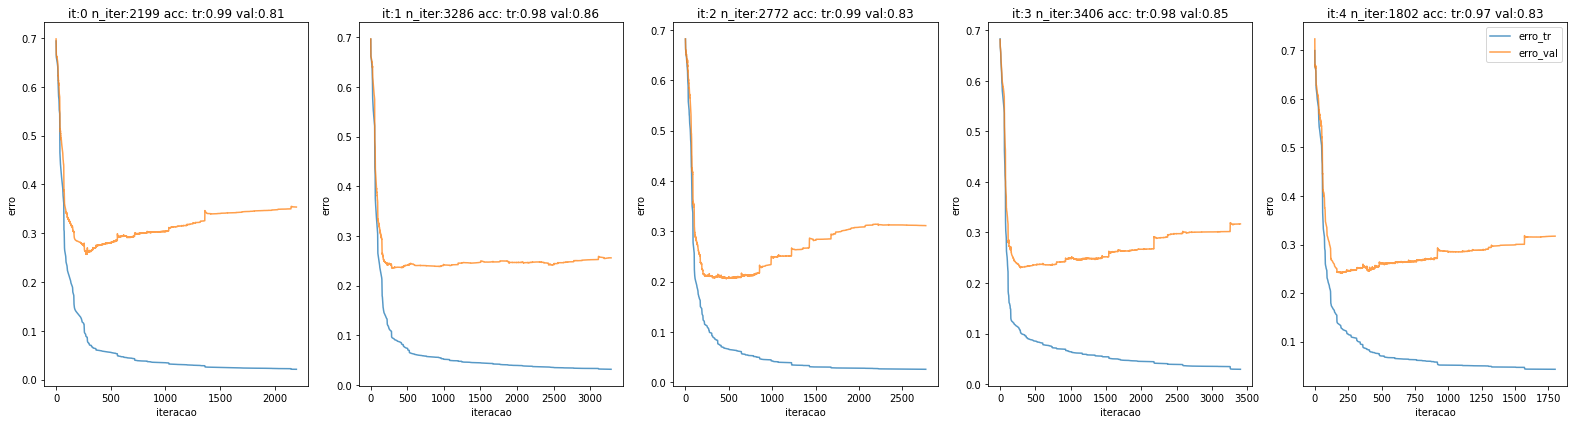

Usando 15 neuronios


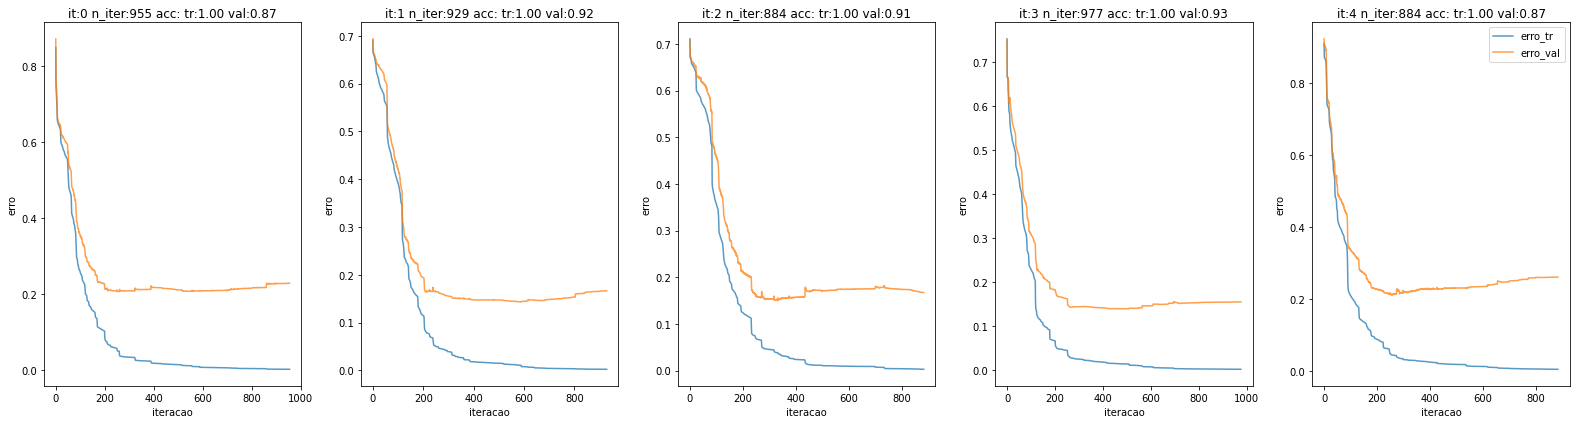

Usando 20 neuronios


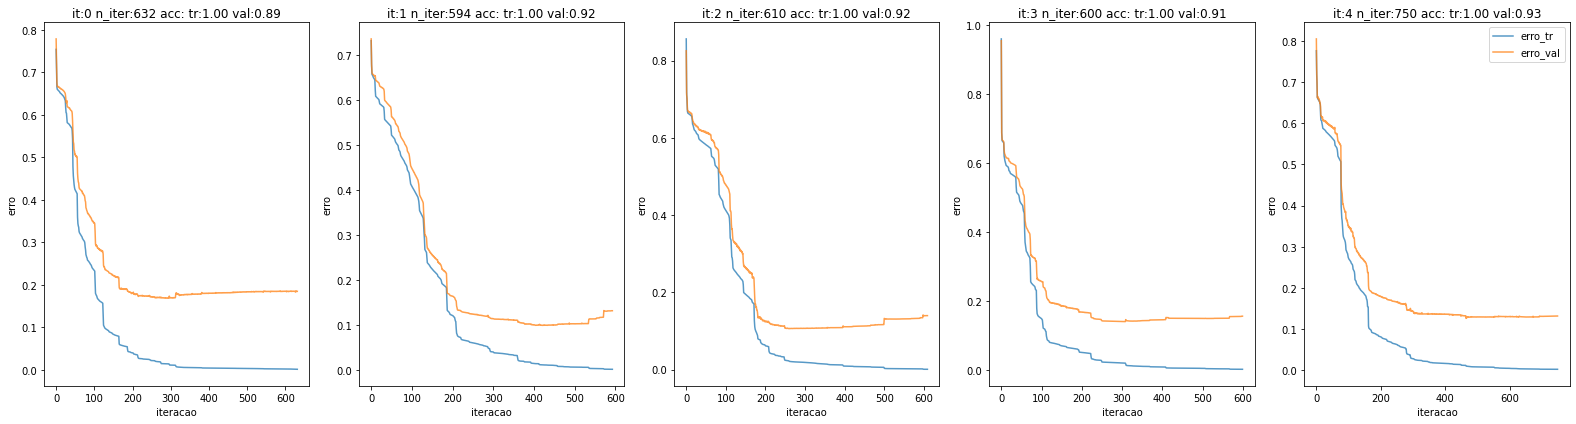

Usando 25 neuronios


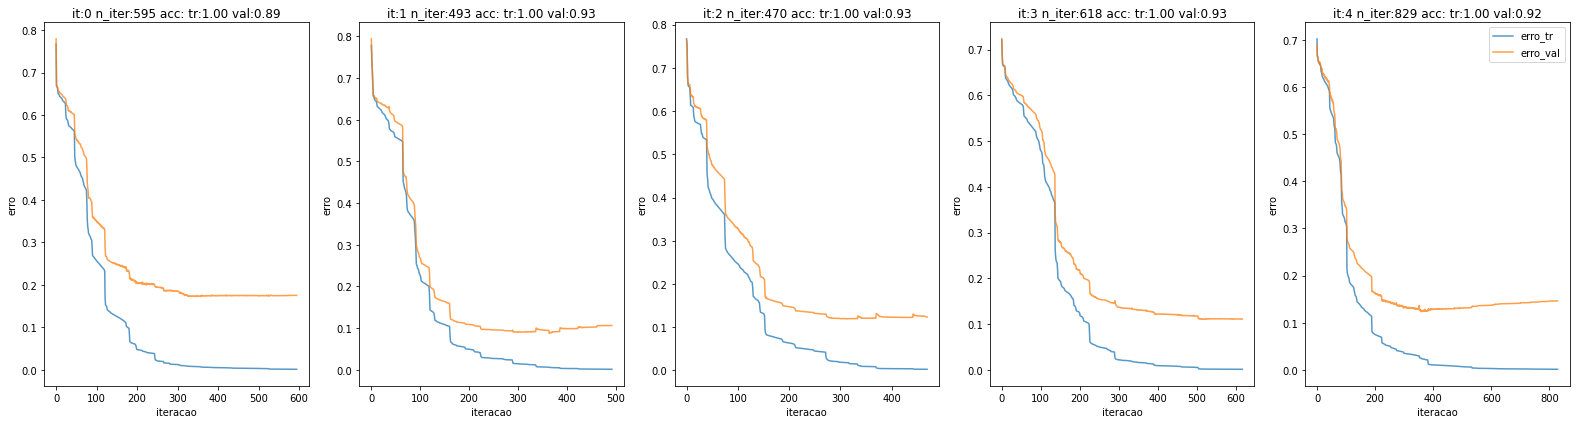

Usando 50 neuronios


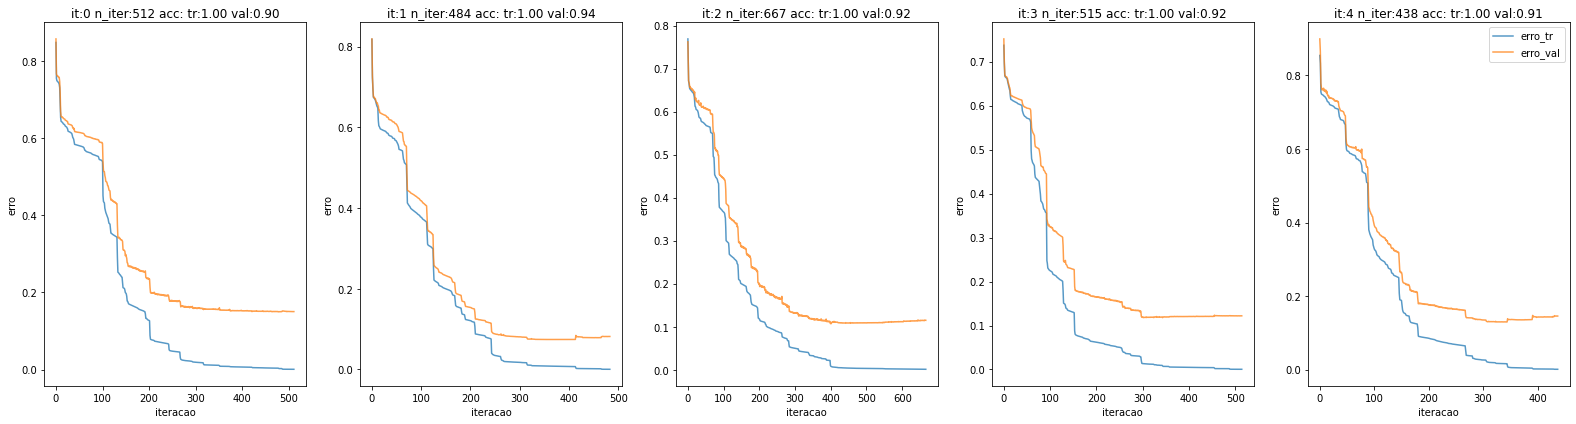

Usando 100 neuronios
nep: 1000 EQM: 0.002188590150059834 EQM_val: 0.11273495325825285 norm: 0.00041596451143332115 alfa: 97.09932755354818


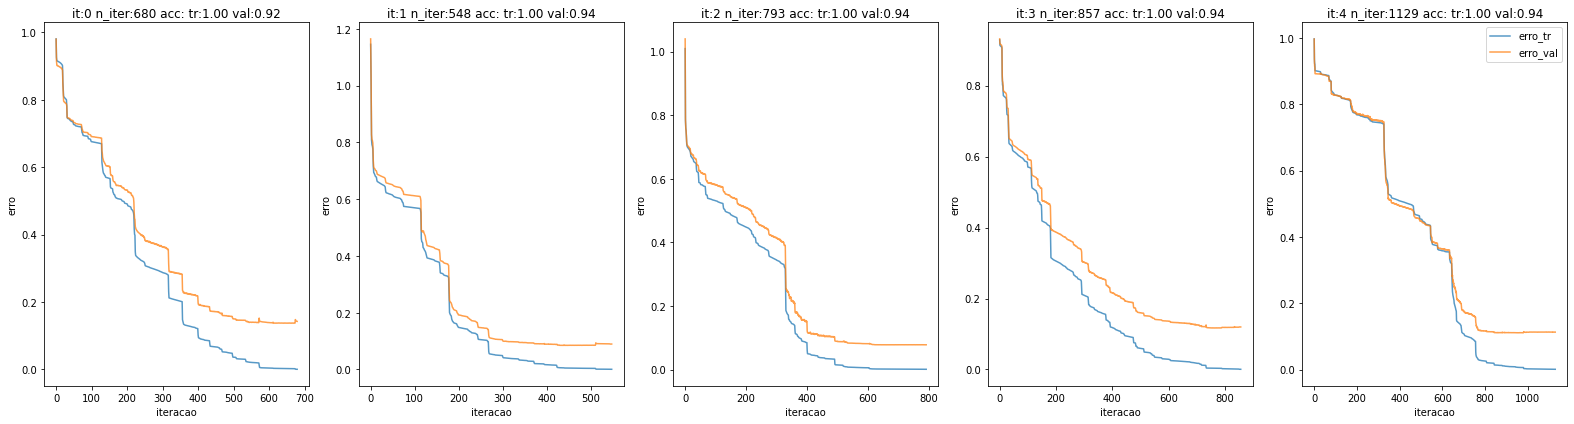

round: 4
Usando 5 neuronios
nep: 1000 EQM: 0.24645878608836472 EQM_val: 0.4477907746508877 norm: 0.0018071222667085456 alfa: 5162.207622587102
nep: 1000 EQM: 0.26741418659663346 EQM_val: 0.4180624940536937 norm: 0.0001474622064574097 alfa: 14.514803751507376
nep: 1000 EQM: 0.30682934545293417 EQM_val: 0.5024139964423917 norm: 0.00036483221652865383 alfa: 10.39037080945668
nep: 2000 EQM: 0.292306867252523 EQM_val: 0.54974533198962 norm: 0.00045603370906152147 alfa: 23.569359257207452
nep: 1000 EQM: 0.27667504496441897 EQM_val: 0.5025857504518148 norm: 0.00028885295244858667 alfa: 13.069246871635876
nep: 1000 EQM: 0.2714695951769866 EQM_val: 0.5077766441758581 norm: 0.0007729248196941968 alfa: 264.0002547365992


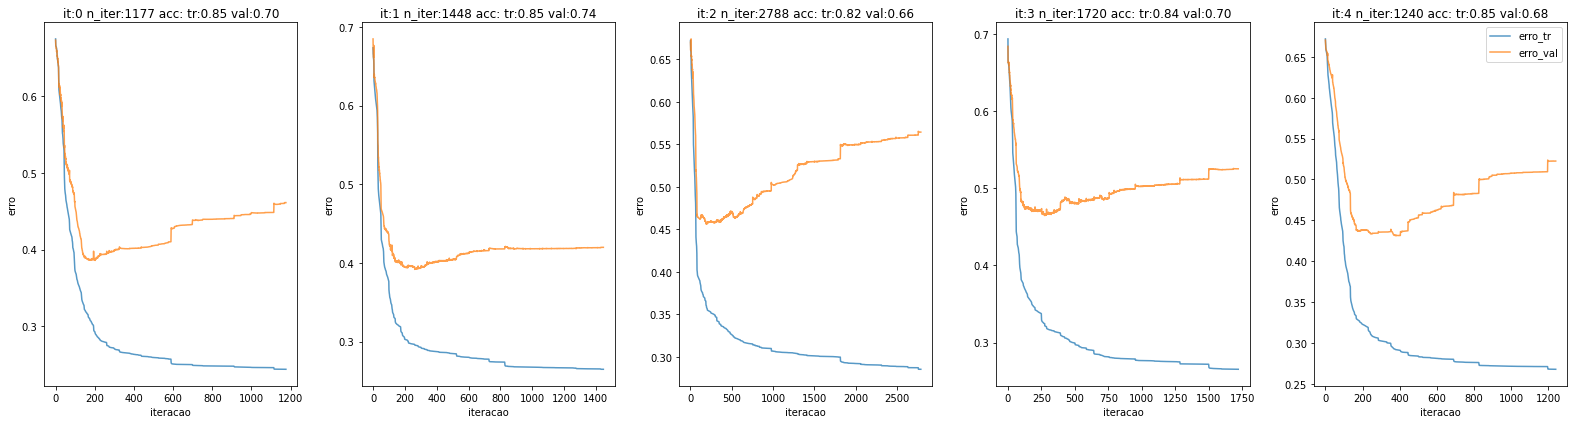

Usando 10 neuronios
nep: 1000 EQM: 0.0475426151775893 EQM_val: 0.3131684482536156 norm: 0.0005654226810473475 alfa: 10.428293822300564
nep: 2000 EQM: 0.03755807238977145 EQM_val: 0.3430241640741301 norm: 0.00020667870012569444 alfa: 7.894406780307932
nep: 1000 EQM: 0.038926200100397046 EQM_val: 0.2335499878982198 norm: 0.0005408279803331935 alfa: 8.849896923534386
nep: 2000 EQM: 0.02591672750640619 EQM_val: 0.26711598538775744 norm: 0.0006354547915434406 alfa: 5.66309152568892
nep: 1000 EQM: 0.05036026959565095 EQM_val: 0.321053910003128 norm: 0.0017681335283027558 alfa: 394.96341616101654
nep: 2000 EQM: 0.0407223500956512 EQM_val: 0.31121005710311866 norm: 0.00022875044093243008 alfa: 29.1779296452046
nep: 1000 EQM: 0.0671821036621169 EQM_val: 0.3646731012776146 norm: 0.0003628825154230408 alfa: 13.476664686994338
nep: 2000 EQM: 0.05635663008512065 EQM_val: 0.41263356414229535 norm: 0.00020688629654019652 alfa: 3.8328602602882196
nep: 1000 EQM: 0.052270890463606876 EQM_val: 0.28606655

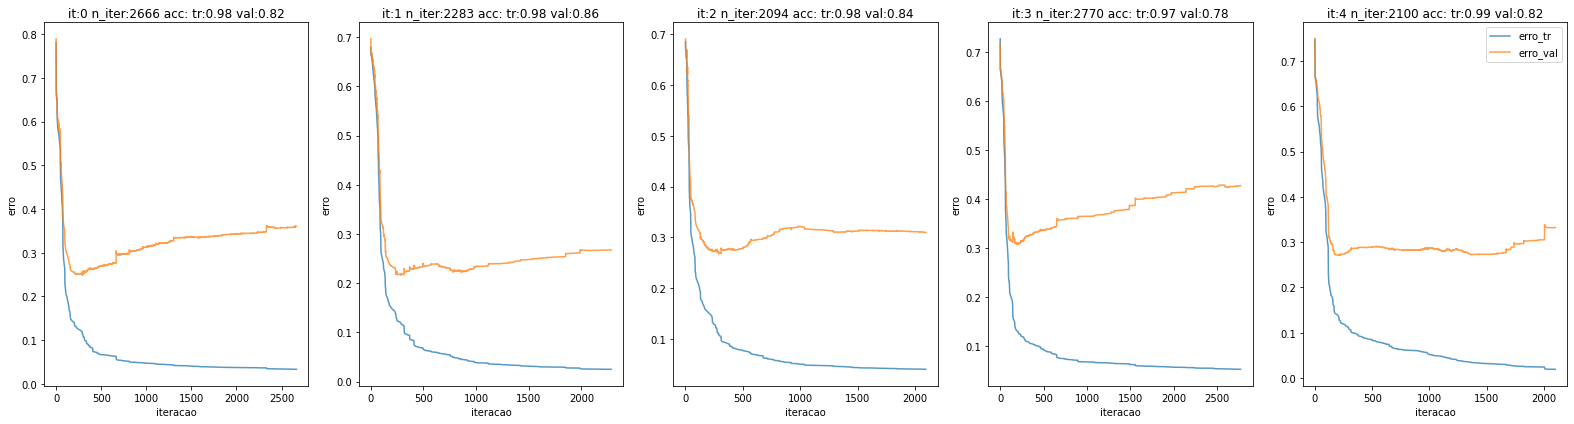

Usando 15 neuronios
nep: 1000 EQM: 0.003667681685131398 EQM_val: 0.15261091377675426 norm: 0.00024333255801003818 alfa: 36.491055656788056
nep: 1000 EQM: 0.006982430186105223 EQM_val: 0.21281855604115488 norm: 0.00022751555953442112 alfa: 14.071604683687632
nep: 1000 EQM: 0.007499449036572224 EQM_val: 0.2639614825768252 norm: 0.0003009069369976427 alfa: 67.72535789638968


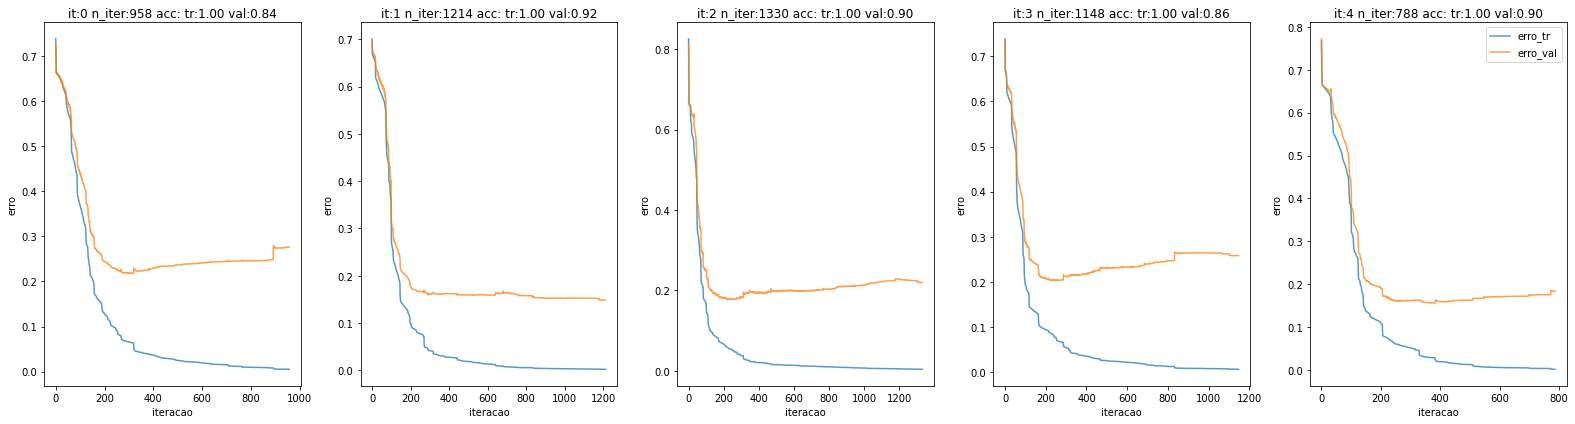

Usando 20 neuronios


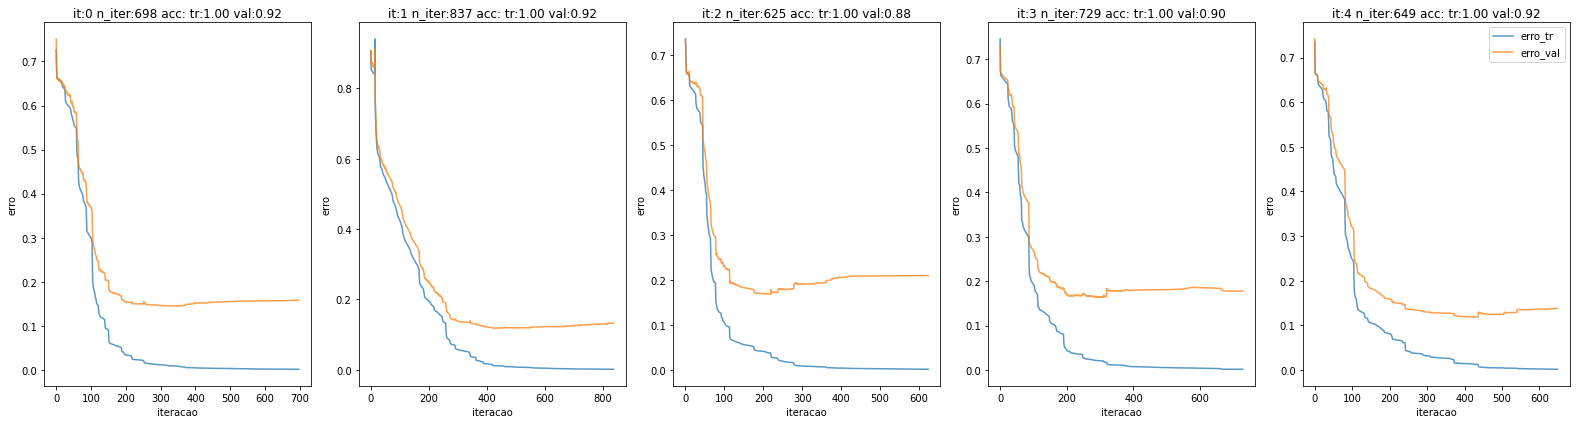

Usando 25 neuronios


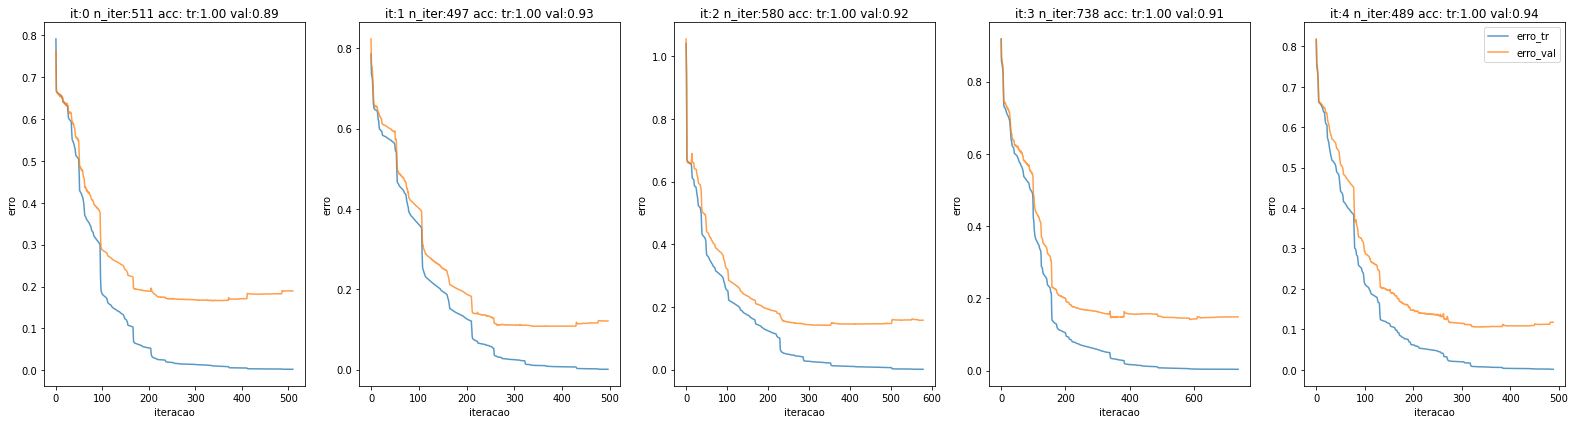

Usando 50 neuronios


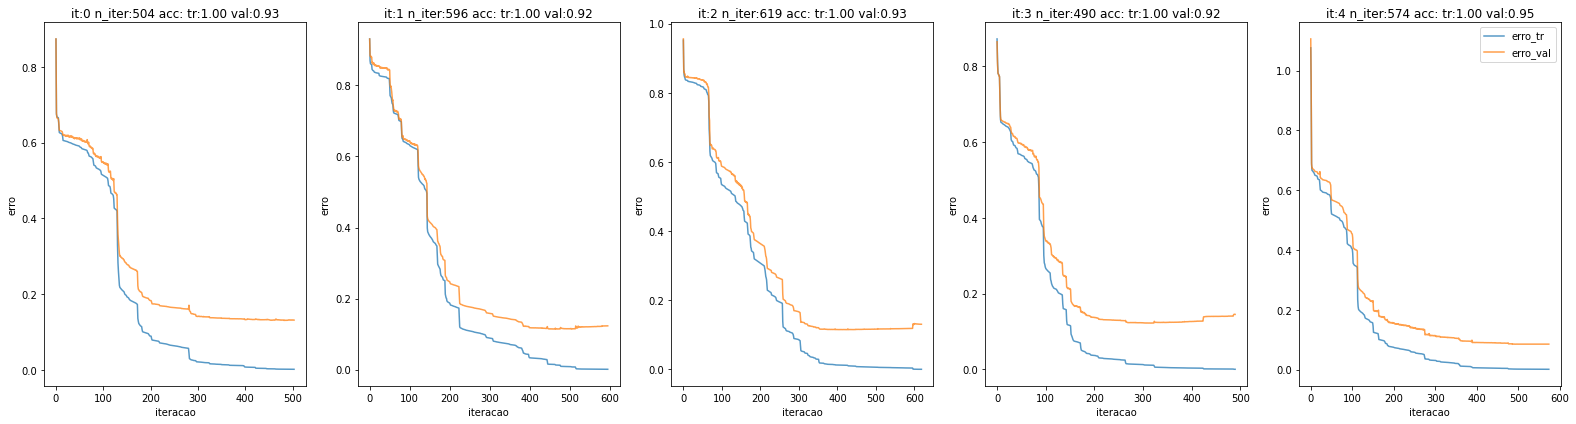

Usando 100 neuronios
nep: 1000 EQM: 0.328912828458135 EQM_val: 0.42172930688690324 norm: 0.0002708019372432707 alfa: 18.017876235262168


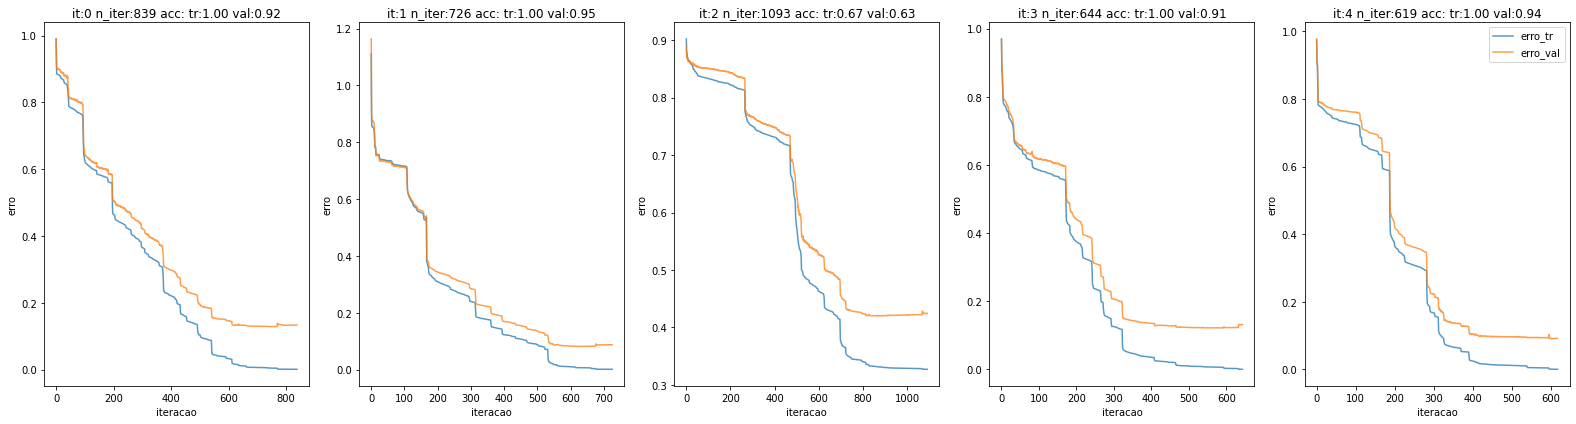

{'0': ('100', 1.0, 0.9090909090909091),
 '1': ('50', 1.0, 0.958041958041958),
 '2': ('100', 1.0, 0.9440559440559441),
 '3': ('100', 1.0, 0.9440559440559441),
 '4': ('50', 1.0, 0.9557109557109557)}

In [ ]:
rna_b = RNA_Bissecao()
h_values =  [5,10,15,20,25,50,100]
pipe = PipeLine_wPCA(rna_b, X_all, y_all, h_values,rounds=5)
pipe.hold_out_n_round()